# Checks with Omar

In [1]:
# imports

from __future__ import print_function
from __future__ import division
from builtins import map
import universe
from universe import *

import halo_fit
from halo_fit import *

import weight
from weight import *


import pn_2d
from pn_2d import *

import cmb
from cmb import *

import flat_map
from flat_map import *

import pandas as pd

import cmb_ilc
from cmb_ilc import *

import scipy

from headers import*

from SO_noise2 import*

from scipy.interpolate import interp1d

In [2]:
##################################################################################
# make plots prettier
import matplotlib
from matplotlib.pyplot import rc
import matplotlib.font_manager

rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})

matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25
matplotlib.rcParams['legend.fontsize'] = 25
#matplotlib.rcParams['legend.title_fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.width'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Is $C^{\kappa\kappa}_\ell$ unbiased?

In [26]:
lCen = np.genfromtxt('lCen.txt')
lEdges = np.genfromtxt('lEdges.txt')
mean = np.genfromtxt('mean_power.txt')
std = np.genfromtxt('std_power.txt')
thy = np.genfromtxt('theory_power.txt')
thyN = np.genfromtxt('noise_power.txt')
thy_dumb = np.genfromtxt('theory_dumb.txt')

Text(0.5, 0, '$L$')

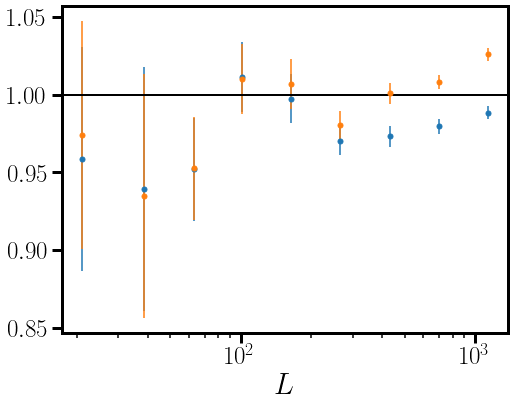

In [31]:
plt.figure(figsize=(8,6))

I = np.where((lCen>20)*(lCen<1500))

plt.errorbar(lCen[I],mean[I]/thy[I],yerr=std[I]/np.sqrt(50)/thy[I],ls='',marker='.',markersize=10)
plt.errorbar(lCen[I],mean[I]/thy_dumb[I],yerr=std[I]/np.sqrt(50)/thy_dumb[I],ls='',marker='.',markersize=10)
plt.axhline(1,0,1000,c='k',lw=2)

plt.xscale('log')

plt.xlabel(r'$L$')

# Setup

In [10]:
### CHANGE BACK TO SO GOAL NOISE LEVELS


# Specifications
Nu = np.array([27.e9,39.e9,93.e9,145.e9,225.e9,280.e9]) # [Hz]
Beam = np.array([7.4,5.1,2.2,1.4,1.0,0.9])
#Noise = np.array([71., 36., 8., 10., 22., 54.])  # [muK*arcmin]
Noise = np.array([52.,27.,5.8,6.3,15.,37.])
#Noise = np.array([71.,36.,8.,10.,22.,54.])

# init

cmbIlc = CMBILC(Nu, Beam, Noise, atm=True)

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/Berkeley/LensQuEst-1/cmb.py:127: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:135: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:149: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl


In [11]:
mode=2 # goal sensitivity
fsky=0.4
N_LF=1.
N_MF=4.
N_UHF=2.
ellmax=1e4
ell, N_ell_LA_T,N_ell_LA_Pol,WN_levels = Simons_Observatory_V3_LA_noise(mode,fsky,ellmax,1,N_LF,N_MF,N_UHF)

In [12]:
lMin = 10.
lMax = 3500.

LMin = 20.
LMax = 1.e3

nBands = 6
nBins = 21

octantArea = 4.*np.pi * (180./np.pi)**2   # deg 2
octantArea /= 8.
ourArea = 81. * 20.**2  # deg 2
uncertaintyFactor = np.sqrt(ourArea / octantArea)

data = pd.read_csv('output/mean_biases.csv')
data2 = pd.read_csv('output/Ckk_biases_lmaxT_3500.csv')
lCen = np.array(data['lCen'])
I = np.where((lCen>=LMin)*(lCen<=LMax))
lEdges = np.logspace(np.log10(1.), np.log10(np.max(15273.50)), nBins, 10.) # Edges of the bins
Nmodes = np.array(data2['Nmodes'])

In [13]:
nX = 400
nY = 400
size = 10.  # degrees, determined by the Sehgal cutouts
baseMap = FlatMap(nX=nX, nY=nY, sizeX=size*np.pi/180., sizeY=size*np.pi/180.)

In [14]:
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
w_lsstgold = WeightTracerLSSTGold(u)
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)
ClkCmb = p2d_cmblens.fPinterp(lCen)

p2d_lsstgold = P2dAuto(u, halofit, w_lsstgold, fPnoise=lambda l:1./w_lsstgold.ngal, nProc=3, save=True)
p2d_lsstgoldcmblens = P2dCross(u, halofit, w_lsstgold, w_cmblens, nProc=3, save=True)
Ckg = p2d_lsstgoldcmblens.fPtotinterp(lCen)
Cgg = p2d_lsstgold.fPtotinterp(lCen)

L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 501, 10.)

weightsIlcCmb = np.array([cmbIlc.weightsIlcCmb(l) for l in L])

weightsIlcCmb_jointDeproj = np.array([cmbIlc.weightsDeprojTszCIB(l) for l in L])

weightsIlcCmb_tszdeproj = np.array([cmbIlc.weightsDeprojTsz(l) for l in L])

weightsIlcCmb_cibdeproj = np.array([cmbIlc.weightsDeprojCIB(l) for l in L])

In [8]:
def ctot(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def ctot_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def ctot_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def ctot_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [9]:
fCtotal = np.array([ctot(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
fCtotal_deproj = np.array([ctot_deproj(l,lindex) for lindex,l in enumerate(L)])
fCtotal_tszdeproj = np.array([ctot_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCtotal_cibdeproj = np.array([ctot_cibdeproj(l,lindex) for lindex,l in enumerate(L)])

# Check with SO noise calculator

(0.0, 6000.0)

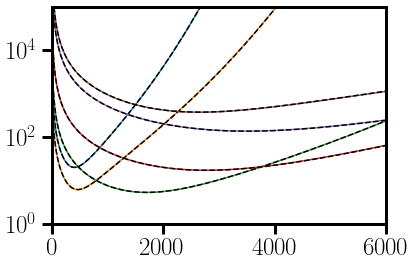

In [15]:
def plot(i): plt.semilogy(ell,(cmbIlc.cmb[i,i].fatmosphericNoiseTT(ell) + cmbIlc.cmb[i,i].fdetectorNoise(ell))*ell*(ell+1)/2/np.pi)

for i in range(6): 
   plot(i)    
   plt.semilogy(ell,N_ell_LA_T[i]*ell*(ell+1)/(2.*np.pi),c='k',ls='--')
    
plt.ylim(1,1e5)
plt.xlim(0,6000)

(0.0, 6000.0)

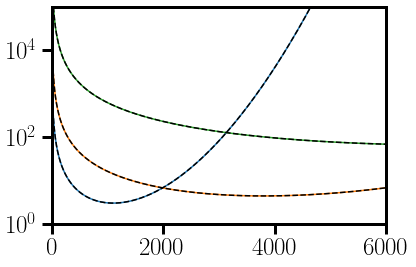

In [16]:
plt.semilogy(ell,(cmbIlc.cmb[0,1].fatmosphericNoiseTT(ell) + cmbIlc.cmb[0,1].fdetectorNoise(ell))*ell*(ell+1)/2/np.pi)
plt.semilogy(ell,(cmbIlc.cmb[2,3].fatmosphericNoiseTT(ell) + cmbIlc.cmb[2,3].fdetectorNoise(ell))*ell*(ell+1)/2/np.pi)
plt.semilogy(ell,(cmbIlc.cmb[4,5].fatmosphericNoiseTT(ell) + cmbIlc.cmb[4,5].fdetectorNoise(ell))*ell*(ell+1)/2/np.pi)

plt.semilogy(ell,N_ell_LA_T[6]*ell*(ell+1)/(2.*np.pi),c='k',ls='--')
plt.semilogy(ell,N_ell_LA_T[7]*ell*(ell+1)/(2.*np.pi),c='k',ls='--')
plt.semilogy(ell,N_ell_LA_T[8]*ell*(ell+1)/(2.*np.pi),c='k',ls='--')

plt.ylim(1,1e5)
plt.xlim(0,6000)

# Check 0. Stuff to send to Omar. 

In [12]:
ells = np.arange(0,8e3,1)
#
ftSZ = cmbIlc.cmb[3,3].ftSZ(ells)
fkSZ = cmbIlc.cmb[3,3].fkSZ(ells)
fCIB = cmbIlc.cmb[3,3].fCIB(ells)
fradiops = cmbIlc.cmb[3,3].fradioPoisson(ells)
ftSZ_CIB = cmbIlc.cmb[3,3].ftSZ_CIB(ells)
fgalacticDust = cmbIlc.cmb[3,3].fgalacticDust(ells)
ftotal = cmbIlc.cmb[3,3].ftotalTT(ells)
#
fdetectorNoise27 = cmbIlc.cmb[0,0].fdetectorNoise(ells)
fatmosphericNoise27 = cmbIlc.cmb[0,0].fatmosphericNoiseTT(ells)
fdetectorNoise39 = cmbIlc.cmb[1,1].fdetectorNoise(ells)
fatmosphericNoise39 = cmbIlc.cmb[1,1].fatmosphericNoiseTT(ells)
fdetectorNoise93 = cmbIlc.cmb[2,2].fdetectorNoise(ells)
fatmosphericNoise93 = cmbIlc.cmb[2,2].fatmosphericNoiseTT(ells)
fdetectorNoise145 = cmbIlc.cmb[3,3].fdetectorNoise(ells)
fatmosphericNoise145 = cmbIlc.cmb[3,3].fatmosphericNoiseTT(ells)
fdetectorNoise225 = cmbIlc.cmb[4,4].fdetectorNoise(ells)
fatmosphericNoise225 = cmbIlc.cmb[4,4].fatmosphericNoiseTT(ells)
fdetectorNoise280 = cmbIlc.cmb[5,5].fdetectorNoise(ells)
fatmosphericNoise280 = cmbIlc.cmb[5,5].fatmosphericNoiseTT(ells)

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/Berkeley/LensQuEst-1/cmb.py:163: RuntimeWarning: invalid value encountered in multiply
  result = a_CIBP * (l/3000.)**2 * self.fdl_to_cl(l)
/home/noah/Berkeley/LensQuEst-1/cmb.py:175: RuntimeWarning: invalid value encountered in multiply
  result = a_CIBC * (l/3000.)**(2-n) * self.fdl_to_cl(l)
/home/noah/Berkeley/LensQuEst-1/cmb.py:191: RuntimeWarning: invalid value encountered in multiply
  result = a_s * (l/3000.)**2* self.fdl_to_cl(l)
/home/noah/Berkeley/LensQuEst-1/cmb.py:203: RuntimeWarning: divide by zero encountered in power
  result = a_gs * (l/3000.)**n_g * self.fdl_to_cl(l) # used to be square instead of n_g?
/home/noah/Berkeley/LensQuEst-1/cmb.py:246: RuntimeWarning: divide by zero encountered in true_divide
  result = (lKnee/l)**(-alpha) * np.exp(l*(l+1)*sigma_beam**2)


In [13]:
def save_spectrum(name,spectrum):
    x = np.array([ells,spectrum]).T
    np.savetxt('for_omar/'+name,x)

In [14]:
save_spectrum('tSZ_145.txt',ftSZ)
save_spectrum('kSZ_145.txt',fkSZ)
save_spectrum('CIB_145.txt',fCIB)
save_spectrum('radioPS_145.txt',fradiops)
save_spectrum('tSZ_CIB_145.txt',ftSZ_CIB)
save_spectrum('galacticDust_145.txt',fgalacticDust)
save_spectrum('total_145.txt',ftotal)
#
save_spectrum('detectorNoise_27.txt',fdetectorNoise27)
save_spectrum('atmosphericNoise_27.txt',fatmosphericNoise27)
save_spectrum('detectorNoise_39.txt',fdetectorNoise39)
save_spectrum('atmosphericNoise_39.txt',fatmosphericNoise39)
save_spectrum('detectorNoise_93.txt',fdetectorNoise93)
save_spectrum('atmosphericNoise_93.txt',fatmosphericNoise93)
save_spectrum('detectorNoise_145.txt',fdetectorNoise145)
save_spectrum('atmosphericNoise_145.txt',fatmosphericNoise145)
save_spectrum('detectorNoise_225.txt',fdetectorNoise225)
save_spectrum('atmosphericNoise_225.txt',fatmosphericNoise225)
save_spectrum('detectorNoise_280.txt',fdetectorNoise280)
save_spectrum('atmosphericNoise_280.txt',fatmosphericNoise280)

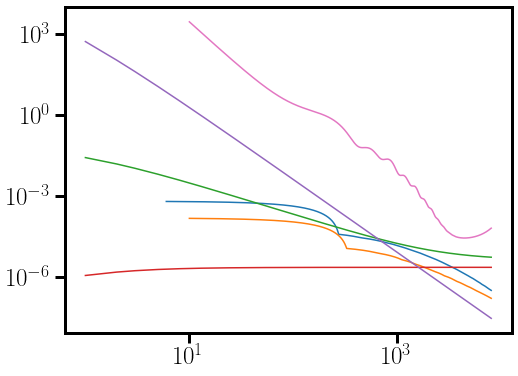

In [15]:
plt.figure(figsize=(8,6))

plt.loglog(ells,ftSZ)
plt.loglog(ells,fkSZ)
plt.loglog(ells,fCIB)
plt.loglog(ells,fradiops)
plt.loglog(ells,fgalacticDust)
plt.loglog(ells,ftSZ_CIB)
plt.loglog(ells,ftotal)

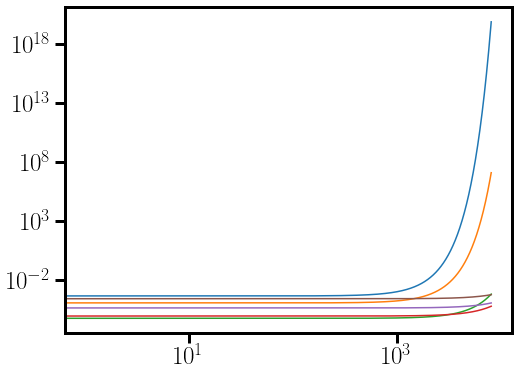

In [16]:
plt.figure(figsize=(8,6))

plt.loglog(ells,fdetectorNoise27)
plt.loglog(ells,fdetectorNoise39)
plt.loglog(ells,fdetectorNoise93)
plt.loglog(ells,fdetectorNoise145)
plt.loglog(ells,fdetectorNoise225)
plt.loglog(ells,fdetectorNoise280)

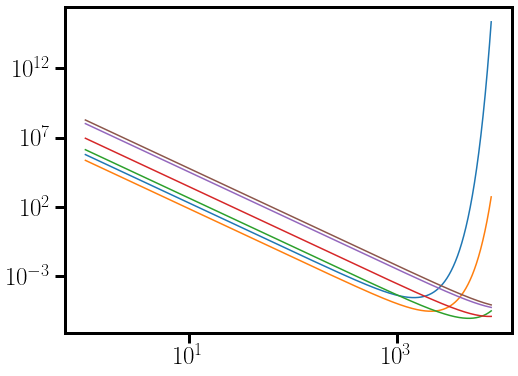

In [17]:
plt.figure(figsize=(8,6))

plt.loglog(ells,fatmosphericNoise27)
plt.loglog(ells,fatmosphericNoise39)
plt.loglog(ells,fatmosphericNoise93)
plt.loglog(ells,fatmosphericNoise145)
plt.loglog(ells,fatmosphericNoise225)
plt.loglog(ells,fatmosphericNoise280)

In [18]:
nus = np.linspace(Nu[0],Nu[-1],100)

tszFreqDpdceT = cmbIlc.cmb[3,3].tszFreqDpdceT(nus)/cmbIlc.cmb[3,3].tszFreqDpdceT(145e9)
kszFreqDpdceT = cmbIlc.cmb[3,3].kszFreqDpdceT(nus)/cmbIlc.cmb[3,3].kszFreqDpdceT(145e9)
cibFreqDpdceT = cmbIlc.cmb[3,3].cibPoissonFreqDpdceT(nus)/cmbIlc.cmb[3,3].cibPoissonFreqDpdceT(145e9)
radioPoissonFreqDpdceT = cmbIlc.cmb[3,3].radioPoissonFreqDpdceT(nus)/cmbIlc.cmb[3,3].radioPoissonFreqDpdceT(145e9)
galacticDustFreqDpdceT = cmbIlc.cmb[3,3].galacticDustFreqDpdceT(nus)/cmbIlc.cmb[3,3].galacticDustFreqDpdceT(145e9)

def save_SED(name,SED):
    x = np.array([nus,SED]).T
    np.savetxt('for_omar/'+name,x)

In [19]:
save_SED('tSZ_SED_T_vs_nu.txt',tszFreqDpdceT)
save_SED('kSZ_SED_T_vs_nu.txt',kszFreqDpdceT)
save_SED('CIB_SED_T_vs_nu.txt',cibFreqDpdceT)
save_SED('radioPS_SED_T_vs_nu.txt',radioPoissonFreqDpdceT)
save_SED('galacticDust_SED_T_vs_nu.txt',galacticDustFreqDpdceT)

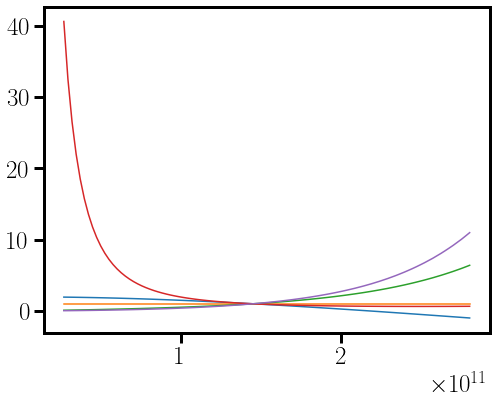

In [20]:
plt.figure(figsize=(8,6))

plt.plot(nus,tszFreqDpdceT)
plt.plot(nus,kszFreqDpdceT)
plt.plot(nus,cibFreqDpdceT)
plt.plot(nus,radioPoissonFreqDpdceT)
plt.plot(nus,galacticDustFreqDpdceT)

# Check 0.5. Foreground power spectra

In [21]:
def get(i):
   n = str(int(Nu[i]/1e9))
   return np.genfromtxt('ilcresultschecknoah/tSZth_'+n+'_'+n+'.txt')

tSZ_omar = np.array([get(i) for i in range(6)])

In [22]:
def get(i):
   n = str(int(Nu[i]/1e9))
   return np.genfromtxt('ilcresultschecknoah/CIBth_'+n+'_'+n+'.txt')

CIB_omar = np.array([get(i) for i in range(6)])

In [23]:
def get(i):
   n = str(int(Nu[i]/1e9))
   return np.genfromtxt('ilcresultschecknoah/radiopsth_'+n+'_'+n+'.txt')

radiops_omar = np.array([get(i) for i in range(6)])

In [24]:
def get(i):
   n = str(int(Nu[i]/1e9))
   return np.genfromtxt('ilcresultschecknoah/kszth_'+n+'_'+n+'.txt')

kSZ_omar = np.array([get(i) for i in range(6)])

In [25]:
def get(i):
   n = str(int(Nu[i]/1e9))
   return np.genfromtxt('ilcresultschecknoah/tSZ_CIBth_'+n+'_'+n+'.txt')

tSZ_CIB_omar = np.array([get(i) for i in range(6)])

In [26]:
def get(i):
   n = str(int(Nu[i]/1e9))
   return np.genfromtxt('ilcresultschecknoah/totalfgth_'+n+'_'+n+'.txt')

total_omar = np.array([get(i) for i in range(6)])

Text(0.5, 0, '$\\ell$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


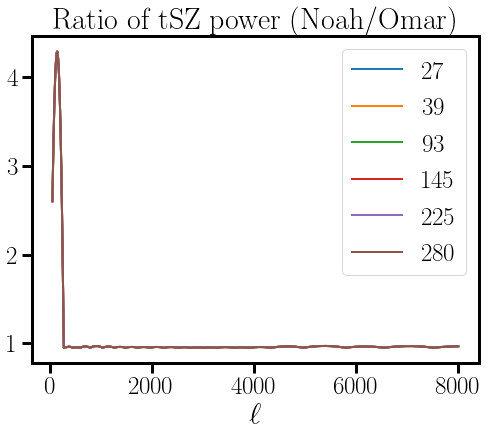

In [27]:
# tSZ
plt.figure(figsize=(8,6))
ells = np.arange(50,8000,1)
for i in range(6): 
   omar_interp = interp1d(tSZ_omar[i][:,0],tSZ_omar[i][:,1])
   plt.plot(ells,cmbIlc.cmb[i,i].ftSZ(ells)/omar_interp(ells),lw=2,label=str(int(Nu[i]/1e9)))
plt.legend()
plt.title('Ratio of tSZ power (Noah/Omar)')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

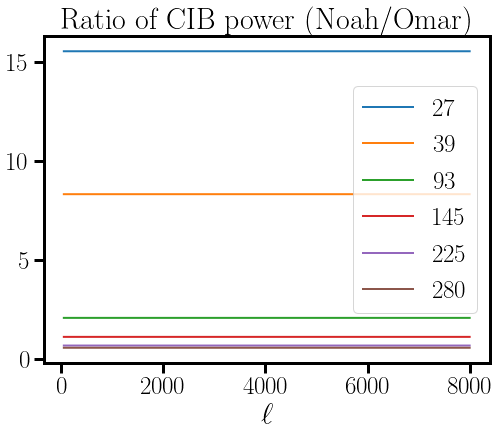

In [28]:
# CIB
plt.figure(figsize=(8,6))
ells = np.arange(50,8000,1)
for i in range(6): 
   omar_interp = interp1d(CIB_omar[i][:,0],CIB_omar[i][:,1])
   plt.plot(ells,cmbIlc.cmb[i,i].fCIB(ells)/omar_interp(ells),lw=2,label=str(int(Nu[i]/1e9)))
plt.legend()
plt.title('Ratio of CIB power (Noah/Omar)')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

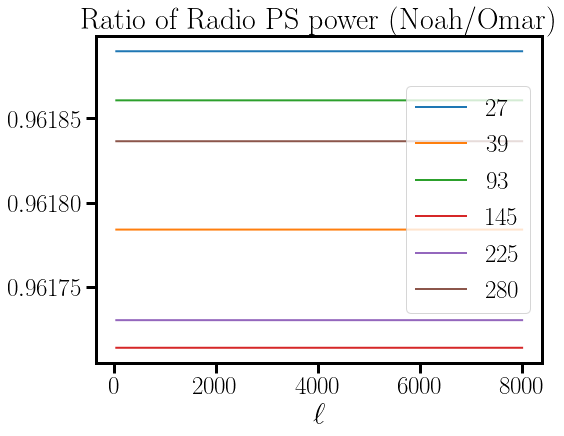

In [29]:
# Radio
plt.figure(figsize=(8,6))
ells = np.arange(50,8000,1)
for i in range(6): 
   omar_interp = interp1d(radiops_omar[i][:,0],radiops_omar[i][:,1])
   plt.plot(ells,cmbIlc.cmb[i,i].fradioPoisson(ells)/omar_interp(ells),lw=2,label=str(int(Nu[i]/1e9)))
plt.legend()
plt.title('Ratio of Radio PS power (Noah/Omar)')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

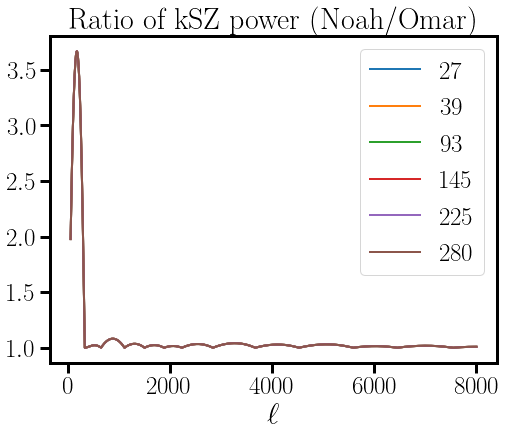

In [30]:
# kSZ
plt.figure(figsize=(8,6))
ells = np.arange(50,8000,1)
for i in range(6): 
   omar_interp = interp1d(kSZ_omar[i][:,0],kSZ_omar[i][:,1])
   plt.plot(ells,cmbIlc.cmb[i,i].fkSZ(ells)/omar_interp(ells),lw=2,label=str(int(Nu[i]/1e9)))
plt.legend()
plt.title('Ratio of kSZ power (Noah/Omar)')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

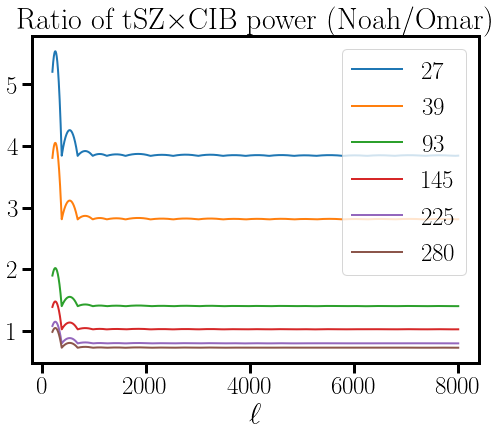

In [31]:
# tSZ_CIB
plt.figure(figsize=(8,6))
ells = np.arange(200,8000,1)
for i in range(6): 
   omar_interp = interp1d(tSZ_CIB_omar[i][:,0],tSZ_CIB_omar[i][:,1])
   plt.plot(ells,cmbIlc.cmb[i,i].ftSZ_CIB(ells)/omar_interp(ells),lw=2,label=str(int(Nu[i]/1e9)))
plt.legend()
plt.title(r'Ratio of tSZ$\times$CIB power (Noah/Omar)')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

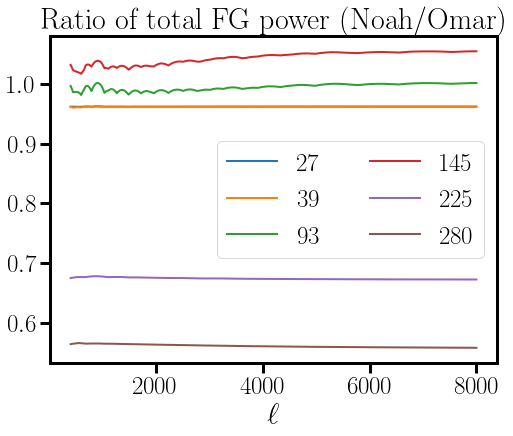

In [32]:
# total
plt.figure(figsize=(8,6))
ells = np.arange(400,8000,1)
for i in range(6): 
   omar_interp = interp1d(total_omar[i][:,0],total_omar[i][:,1])
   tot = lambda l: cmbIlc.cmb[i,i].ftSZ(l)+ cmbIlc.cmb[i,i].fCIB(l)+ cmbIlc.cmb[i,i].fkSZ(l)+ cmbIlc.cmb[i,i].fradioPoisson(l)+ cmbIlc.cmb[i,i].ftSZ_CIB(l)#+cmbIlc.cmb[i,i].fgalacticDust(l)
   plt.plot(ells,tot(ells)/omar_interp(ells),lw=2,label=str(int(Nu[i]/1e9)))
plt.legend(ncol=2)
plt.title(r'Ratio of total FG power (Noah/Omar)')
plt.xlabel(r'$\ell$')

(1e-11, 1)

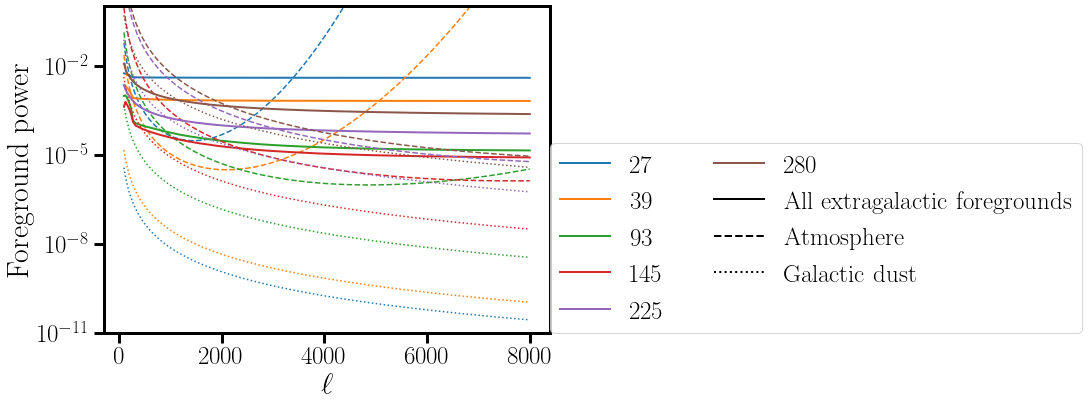

In [33]:
plt.figure(figsize=(8,6))
ells = np.arange(100,8000,1)
for i in range(6): 
   tot = lambda l: cmbIlc.cmb[i,i].ftSZ(l)+ cmbIlc.cmb[i,i].fCIB(l)+ cmbIlc.cmb[i,i].fkSZ(l)+ cmbIlc.cmb[i,i].fradioPoisson(l)+ cmbIlc.cmb[i,i].ftSZ_CIB(l)
   plt.semilogy(ells,tot(ells),lw=2,label=str(int(Nu[i]/1e9)),c='C'+str(i))
   plt.semilogy(ells,cmbIlc.cmb[i,i].fatmosphericNoiseTT(ells),ls='--',c='C'+str(i))
   plt.semilogy(ells,cmbIlc.cmb[i,i].fgalacticDust(ells),ls='dotted',c='C'+str(i))


plt.plot([],[],c='k',lw=2,label='All extragalactic foregrounds')
plt.plot([],[],c='k',lw=2,ls='--',label='Atmosphere')
plt.plot([],[],c='k',lw=2,ls='dotted',label='Galactic dust')

plt.ylabel('Foreground power')

plt.legend(ncol=2,loc=(1,0))
plt.xlabel(r'$\ell$')
plt.ylim(1e-11,1)

In [34]:
pairs = ['27_39',
         '27_93',
         '27_145',
         '27_225',
         '27_280',
         '39_93',
         '39_145',
         '39_225',
         '39_280',
         '93_145',
         '93_225',
         '93_280',
         '145_225',
         '145_280',
         '225_280']

pairs_idx = [[0,1],
             [0,2],  
             [0,3],
             [0,4],
             [0,5],
             [1,2],
             [1,3],
             [1,4],
             [1,5],
             [2,3],
             [2,4],
             [2,5],
             [3,4],
             [3,5],
             [4,5]]

ells = np.arange(1,8000,1)

for i in range(6):
   n = str(int(Nu[i]/1e9))
   d = np.array([ells,cmbIlc.cmb[i,i].fatmosphericNoiseTT(ells)]).T
   np.savetxt('atmospherePower/atm_'+n+'_'+n+'.txt',d)

for i in range(15):
   d = np.array([ells,cmbIlc.cmb[pairs_idx[i][0],pairs_idx[i][1]].fatmosphericNoiseTT(ells)]).T
   np.savetxt('atmospherePower/atm_'+pairs[i]+'.txt',d)

No handles with labels found to put in legend.


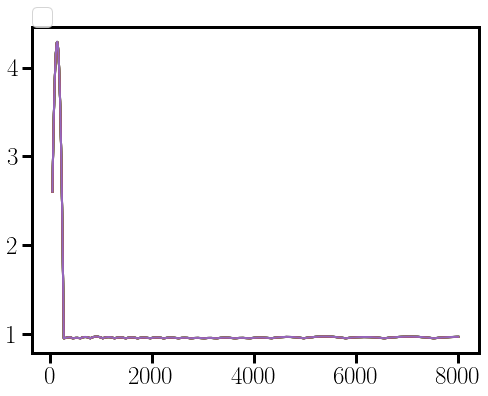

In [35]:
# tSZ crosses

pairs = ['27_39',
         '27_93',
         '27_145',
         '27_225',
         '27_280',
         '39_93',
         '39_145',
         '39_225',
         '39_280',
         '93_145',
         '93_225',
         '93_280',
         '145_225',
         '145_280',
         '225_280']

pairs_idx = [[0,1],
             [0,2],  
             [0,3],
             [0,4],
             [0,5],
             [1,2],
             [1,3],
             [1,4],
             [1,5],
             [2,3],
             [2,4],
             [2,5],
             [3,4],
             [3,5],
             [4,5]]

plt.figure(figsize=(8,6))
for i in range(15):
   f = np.genfromtxt('ilcresultschecknoah/tSZth_'+pairs[i]+'.txt')
   omar_interp = interp1d(f[:,0],f[:,1])
   ells = np.arange(50,8000,1)
   plt.plot(ells,cmbIlc.cmb[pairs_idx[i][0],pairs_idx[i][1]].ftSZ(ells)/omar_interp(ells),lw=2)
plt.legend(loc=(0,1))

Text(0.5, 0, '$\\ell$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


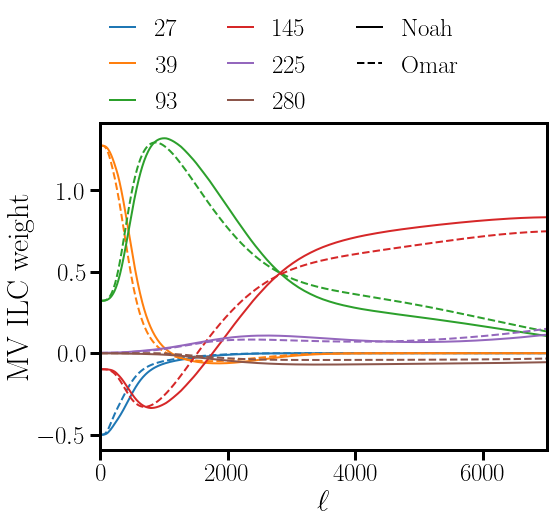

In [17]:
ells = np.genfromtxt('ilcresultschecknoah/w_ilc_total.txt')[:,0]
w_omar = np.genfromtxt('ilcresultschecknoah/w_ilc_total.txt')[:,1:]

plt.figure(figsize=(8,6))

for i in range(6):
   plt.plot(ells,w_omar[:,i],lw=2,ls='--')
   plt.plot(L,weightsIlcCmb[:,i],c='C'+str(i),lw=2,label=round(Nu[i]/1e9))
    
plt.plot([],[],c='k',lw=2,label='Noah')
plt.plot([],[],c='k',lw=2,ls='--',label='Omar')
    
plt.legend(loc=(0,1),ncol=3,handlelength=1,frameon=False)

plt.xlim(0,7000)
plt.ylabel(r'MV ILC weight')
plt.xlabel(r'$\ell$')

In [23]:
dat = np.zeros((7,len(L)))
dat[0] = L
dat[1:] = weightsIlcCmb.T
dat = dat.T

In [24]:
np.savetxt('ILC_weights.txt',dat)

# Check 1. Do our ILC weights/power agree?

In [7]:
directory = "from_omar/"
ells_for_weights_ilc = np.genfromtxt(directory+'ells_for_weights_ilc.txt')
weights_ilc = np.genfromtxt(directory+'weights_ilc.txt')

Text(0.5, 0, '$\\ell$')

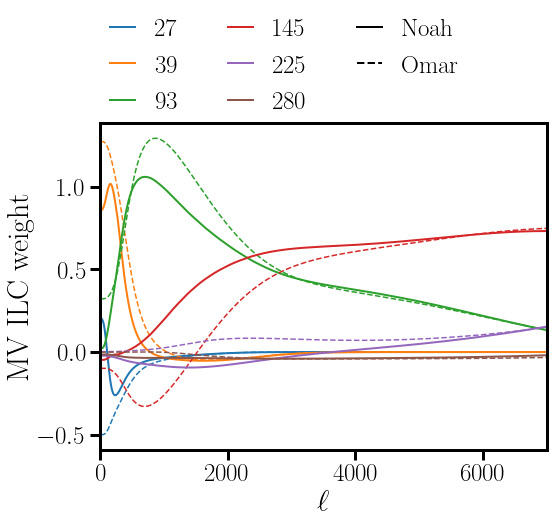

In [9]:
plt.figure(figsize=(8,6))


for i in range(6): 
    plt.plot(L,weightsIlcCmb[:,i],c='C'+str(i),lw=2,label=round(Nu[i]/1e9))
    plt.plot(ells_for_weights_ilc,weights_ilc[:,i],c='C'+str(i),ls='--')

plt.plot([],[],c='k',lw=2,label='Noah')
plt.plot([],[],c='k',lw=2,ls='--',label='Omar')
    
plt.legend(loc=(0,1),ncol=3,handlelength=1,frameon=False)

plt.xlim(0,7000)
plt.ylabel(r'MV ILC weight')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

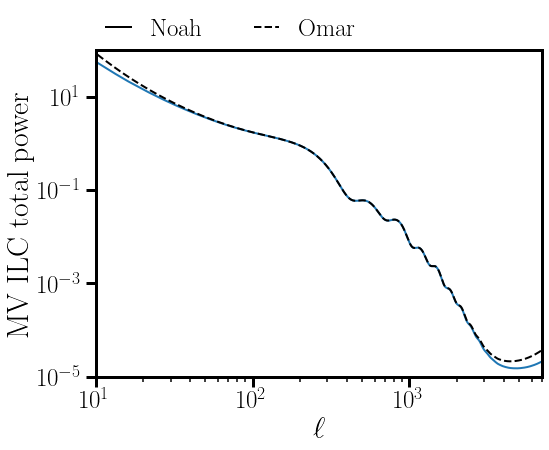

In [51]:
theory_power_ilc = np.genfromtxt(directory+'theory_power_ilc.txt')

plt.figure(figsize=(8,6))
 
plt.semilogx(L,fCtotal,lw=2,c='C0')
plt.semilogy(theory_power_ilc[:,0],theory_power_ilc[:,1],ls='--',c='k',lw=2)

plt.plot([],[],c='k',lw=2,label='Noah')
plt.plot([],[],c='k',lw=2,ls='--',label='Omar')
    
plt.legend(loc=(0,1),ncol=3,handlelength=1,frameon=False)

plt.xlim(10,7000)
plt.ylim(1e-5,1e2)

plt.ylabel(r'MV ILC total power')
plt.xlabel(r'$\ell$')

# Check 2. Do our tSZ deprojection weights/power agree?

In [23]:
weights_depr_tsz_ilc = np.genfromtxt(directory+'weights_depr_tsz_ilc.txt')

Text(0.5, 0, '$\\ell$')

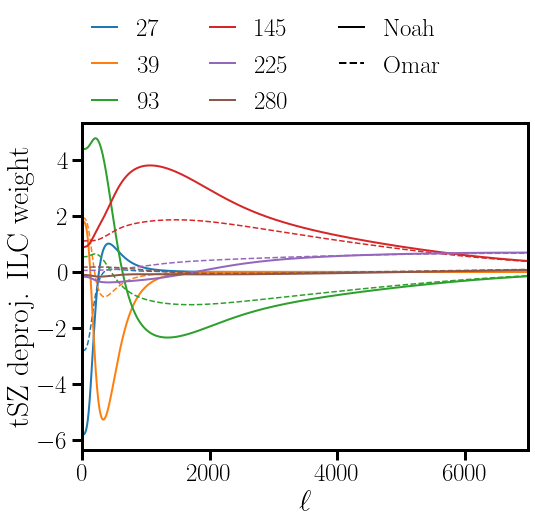

In [48]:
plt.figure(figsize=(8,6))


for i in range(6): 
    plt.plot(L,weightsIlcCmb_tszdeproj[:,i],c='C'+str(i),lw=2,label=round(Nu[i]/1e9))
    plt.plot(ells_for_weights_ilc,weights_depr_tsz_ilc[i,:],c='C'+str(i),ls='--')

plt.plot([],[],c='k',lw=2,label='Noah')
plt.plot([],[],c='k',lw=2,ls='--',label='Omar')
    
plt.legend(loc=(0,1),ncol=3,handlelength=1,frameon=False)

plt.xlim(0,7000)

plt.ylabel(r'tSZ deproj. ILC weight')
plt.xlabel(r'$\ell$')

Text(0.5, 0, '$\\ell$')

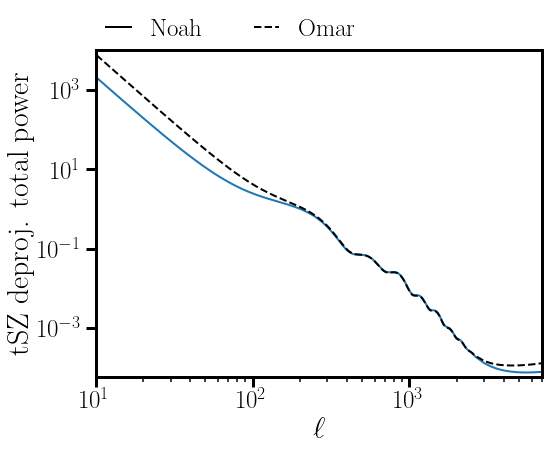

In [45]:
theory_power_tszdepr_ilc = np.genfromtxt(directory+'theory_power_tszdepr_ilc.txt')

plt.figure(figsize=(8,6))
 
plt.semilogx(L,fCtotal_tszdeproj,lw=2,c='C0')
plt.semilogy(theory_power_tszdepr_ilc[:,0],theory_power_tszdepr_ilc[:,1],ls='--',c='k',lw=2)

plt.plot([],[],c='k',lw=2,label='Noah')
plt.plot([],[],c='k',lw=2,ls='--',label='Omar')
    
plt.legend(loc=(0,1),ncol=3,handlelength=1,frameon=False)

plt.xlim(10,7000)
plt.ylim(6e-5,1e4)

plt.ylabel(r'tSZ deproj. total power')
plt.xlabel(r'$\ell$')

# Check 3. Theoretical power spectra

Text(0.5, 0, '$\\ell$')

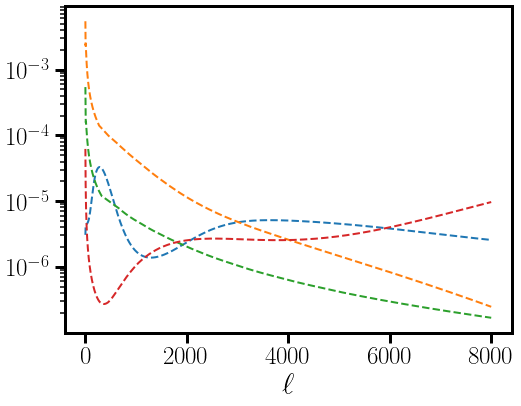

In [63]:
fg_power_ilc_radiops_model = np.genfromtxt(directory+'fg_power_ilc_radiops_model.txt')
fg_power_ilc_tsz_model = np.genfromtxt(directory+'fg_power_ilc_tsz_model.txt')
fg_power_ilc_ksz_model = np.genfromtxt(directory+'fg_power_ilc_ksz_model.txt')
fg_power_ilc_cib_model = np.genfromtxt(directory+'fg_power_ilc_cib_model.txt')

plt.figure(figsize=(8,6))

plt.semilogy(fg_power_ilc_radiops_model[:,0],fg_power_ilc_radiops_model[:,1],lw=2,ls='--',c='C0')
plt.semilogy(fg_power_ilc_radiops_model[:,0],fg_power_ilc_tsz_model[:,1],lw=2,ls='--',c='C1')
plt.semilogy(fg_power_ilc_radiops_model[:,0],fg_power_ilc_ksz_model[:,1],lw=2,ls='--',c='C2')
plt.semilogy(fg_power_ilc_radiops_model[:,0],fg_power_ilc_cib_model[:,1],lw=2,ls='--',c='C3')


plt.xlabel(r'$\ell$')

In [9]:
def cTsz(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def cTsz_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def cTsz_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def cTsz_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [10]:
fCTsz = np.array([cTsz(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
fCTsz_deproj = np.array([cTsz_deproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz_tszdeproj = np.array([cTsz_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz_cibdeproj = np.array([cTsz_cibdeproj(l,lindex) for lindex,l in enumerate(L)])

In [11]:
fCTsz148 = np.array([cmbIlc.cmb[3,3].ftSZ(l) for l in L])

In [12]:
def cCIB(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def cCIB_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def cCIB_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def cCIB_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [13]:
fCCIB = np.array([cCIB(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
fCCIB_deproj = np.array([cCIB_deproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB_tszdeproj = np.array([cCIB_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB_cibdeproj = np.array([cCIB_cibdeproj(l,lindex) for lindex,l in enumerate(L)])

In [14]:
fCCIB148 = np.array([cmbIlc.cmb[3,3].fCIB(l) for l in L])

# Figure 1.

/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


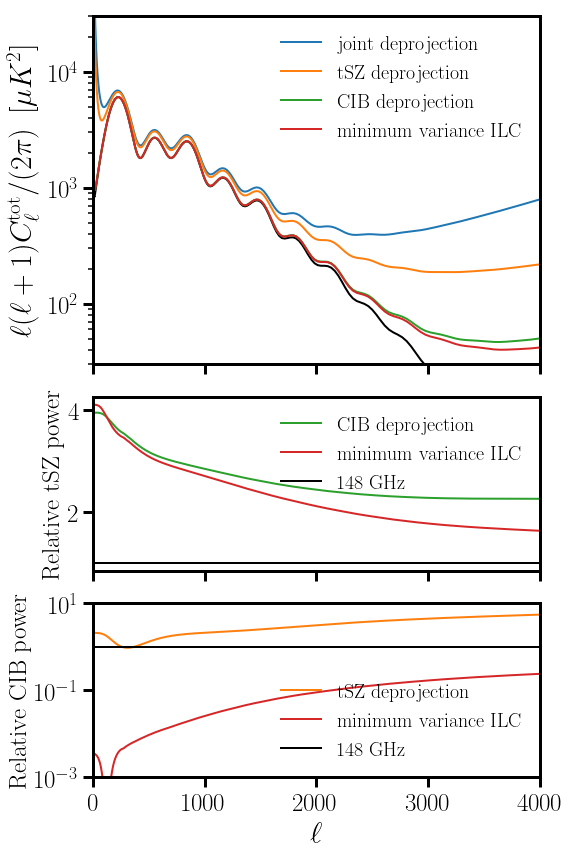

In [15]:
fig,ax = plt.subplots(3,1,figsize=(8,14),sharex=True,gridspec_kw={'height_ratios':[1,0.5,0.5],'hspace':0.14})

signal = np.array([cmbIlc.cmb[0,0].flensedTT(l) for l in L])

ax[0].semilogy(L,signal*L*(L+1)/(2.*np.pi),color='k',lw=2)

ax[0].semilogy(L,fCtotal_deproj*L*(L+1.)/(2.*np.pi),color='C0',label='joint deprojection',lw=2)
ax[0].semilogy(L,fCtotal_tszdeproj*L*(L+1.)/(2.*np.pi),color='C1',label='tSZ deprojection',lw=2)
ax[0].semilogy(L,fCtotal_cibdeproj*L*(L+1.)/(2.*np.pi),color='C2',label='CIB deprojection',lw=2)
ax[0].semilogy(L,fCtotal*L*(L+1.)/(2.*np.pi),color='C3',label='minimum variance ILC',lw=2)

ax[1].plot(L,fCTsz_cibdeproj/fCTsz148,color='C2',lw=2,label='CIB deprojection')
ax[1].plot(L,fCTsz/fCTsz148,color='C3',lw=2,label='minimum variance ILC')
ax[1].plot(L,np.ones(L.shape),c='k',lw='2',label='148 GHz')

ax[2].semilogy(L,fCCIB_tszdeproj/fCCIB148,color='C1',label='tSZ deprojection',lw=2)
ax[2].semilogy(L,fCCIB/fCCIB148,color='C3',label='minimum variance ILC',lw=2)
ax[2].plot(L,np.ones(L.shape),c='k',lw='2',label='148 GHz')


ax[0].set_xlim(0,4000)
ax[0].set_ylim(30,3e4)

ax[2].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\ell(\ell+1)C^\text{tot}_\ell/(2\pi)\,\,\,[\mu K^2]$')
ax[0].legend(loc=0,frameon=False,fontsize=20)
ax[1].legend(loc=0,frameon=False,fontsize=20)
ax[2].legend(loc=0,frameon=False,fontsize=20)

ax[1].set_ylabel(r'Relative tSZ power',fontsize=25)
ax[2].set_ylabel(r'Relative CIB power',fontsize=25)\

ax[2].set_ylim(1e-3,10)

plt.savefig('figures/ILC_noises.pdf',bbox_inches='tight')

# Figure 2.

## Calculating noises

In [16]:
fCtotal = np.array([ctot(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


In [17]:
fCtotal = np.array([ctot_deproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_deproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


In [18]:
fCtotal = np.array([ctot_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_tszdeproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


In [19]:
fCtotal = np.array([ctot_cibdeproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_cibdeproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


## loading biases

In [20]:
def get_data(t):
   outputFolder = "output_t_"+"{0:0=2d}".format(int(t*10))
   sdata = pd.read_csv('ILC_to_Joint/3500/'+outputFolder+'/sigma_biases.csv')*uncertaintyFactor/np.sqrt(81)
   data = pd.read_csv('ILC_to_Joint/3500/'+outputFolder+'/mean_biases.csv')
   return data,sdata

def get_bias_L(e,t,s='All'):
   data,sdata = get_data(t)
   P = np.array(data[e+' primary, '+s])*2
   S = np.array(data[e+' secondary, '+s])*2
   T = np.array(data[e+' trispectrum, '+s])
   bias = (P+S+T)/ClkCmb
   return bias

In [21]:
data = pd.read_csv('ILC_to_Joint/3500/output_t_00/mean_biases.csv')
P,S,T = data['QE primary, All'],data['QE secondary, All'],data['QE trispectrum, All']
bias = P+S+T

data = pd.read_csv('ILC_to_Joint/3500/output_t_10/mean_biases.csv')
P,S,T = data['QE primary, All'],data['QE secondary, All'],data['QE trispectrum, All']
bias_deproj = P+S+T

data = pd.read_csv('ILC_to_CIB/3500/output_t_10/mean_biases.csv')
P,S,T = data['QE primary, All (scale dep)'],data['QE secondary, All (scale dep)'],data['QE trispectrum, All (scale dep)']
bias_cibdeproj = P+S+T

data = pd.read_csv('ILC_to_tSZ/3500/output_t_10/mean_biases.csv')
P,S,T = data['QE primary, All (scale dep)'],data['QE secondary, All (scale dep)'],data['QE trispectrum, All (scale dep)']
bias_tszdeproj = P+S+T

/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


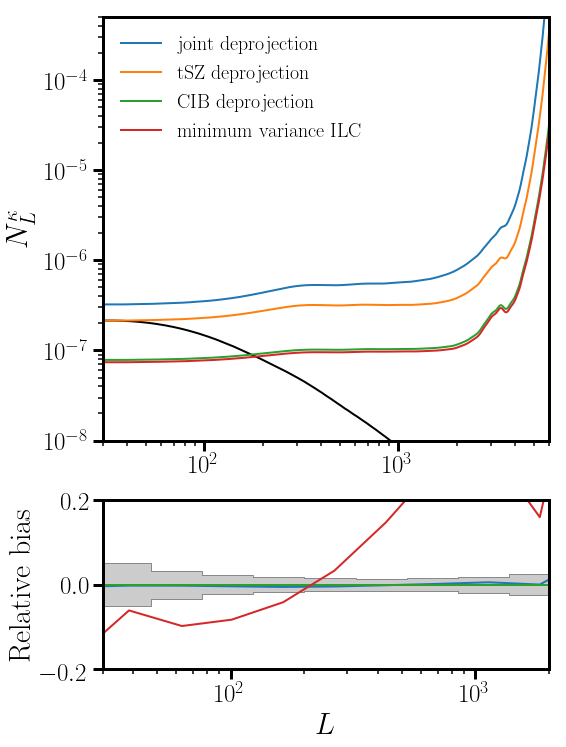

In [22]:
fig,ax = plt.subplots(2,1,figsize=(8,12),gridspec_kw={'height_ratios':[1,0.4],'hspace':0.2})

ax[0].loglog(L,p2d_cmblens.fPinterp(L),c='k',lw=2)
ax[0].loglog(L,fNqCmb_fft_deproj(L),lw=2,c='C0',label='joint deprojection')
ax[0].loglog(L,fNqCmb_fft_tszdeproj(L),lw=2,c='C1',label='tSZ deprojection')
ax[0].loglog(L,fNqCmb_fft_cibdeproj(L),lw=2,c='C2',label='CIB deprojection')
ax[0].loglog(L,fNqCmb_fft(L),lw=2,c='C3',label='minimum variance ILC')


ax[1].semilogx(lCen,bias_deproj,c='C0',lw=2)
ax[1].semilogx(lCen,bias_tszdeproj,c='C1',lw=2)
ax[1].semilogx(lCen,bias_cibdeproj,c='C2',lw=2)
ax[1].semilogx(lCen,bias,c='C3',lw=2)

sigma = np.sqrt(2. * (ClkCmb + fNqCmb_fft(lCen))**2 / Nmodes)
sigma0 = np.array(list(zip(sigma/ClkCmb, sigma/ClkCmb))).flatten()
l0 = np.array(list(zip(lEdges[:-1],lEdges[1:]))).flatten()
ax[1].fill_between(l0, -sigma0, sigma0, edgecolor='k', facecolor='gray', alpha=0.4)

ax[0].set_ylabel(r'$N^\kappa_L$')
ax[1].set_xlabel(r'$L$')
ax[1].set_ylabel(r'Relative bias')

ax[0].legend(loc=0,frameon=False,fontsize=20)

ax[0].set_xlim(30,6000)
ax[0].set_ylim(1e-8,5e-4)

ax[1].set_xlim(30,2000)
ax[1].set_ylim(-0.2,0.2)

plt.savefig('figures/Nk_bias_vs_L.pdf',bbox_inches='tight')

# Figure 3.

(0.0003, 0.1)

/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


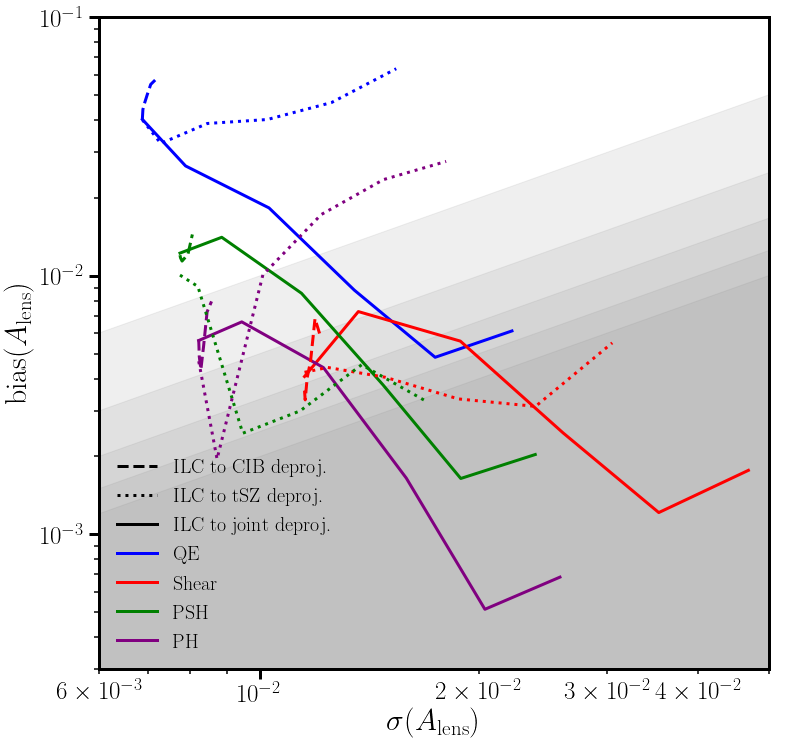

In [182]:
plt.figure(figsize=(12,12))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T

plt.plot(noises_abs[0],biases_abs[0],lw=3,c='b')
plt.plot(noises_abs[1],biases_abs[1],lw=3,c='r')
plt.plot(noises_abs[2],biases_abs[2],lw=3,c='g')
plt.plot(noises_abs[3],biases_abs[3],lw=3,c='purple')


biases_absa = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_absa = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T

plt.plot(noises_absa[0],biases_absa[0],lw=3,c='b',ls='--')
plt.plot(noises_absa[1],biases_absa[1],lw=3,c='r',ls='--')
plt.plot(noises_absa[2],biases_absa[2],markersize=10,lw=3,c='g',ls='--')
plt.plot(noises_absa[3],biases_absa[3],markersize=10,lw=3,c='purple',ls='--')

biases_absb = np.array([biases_abs_00b,biases_abs_02b,biases_abs_04b,biases_abs_06b,biases_abs_08b,biases_abs_10b]).T
noises_absb = np.array([noises_abs_00b,noises_abs_02b,noises_abs_04b,noises_abs_06b,noises_abs_08b,noises_abs_10b]).T

plt.plot(noises_absb[0],biases_absb[0],lw=3,c='b',ls='dotted')
plt.plot(noises_absb[1],biases_absb[1],lw=3,c='r',ls='dotted')
plt.plot(noises_absb[2],biases_absb[2],lw=3,c='g',ls='dotted')
plt.plot(noises_absb[3],biases_absb[3],lw=3,c='purple',ls='dotted')

plt.plot([],[],c='k',lw=3,ls='dashed',label='ILC to CIB deproj.')
plt.plot([],[],c='k',lw=3,ls='dotted',label='ILC to tSZ deproj.')
plt.plot([],[],c='k',lw=3,label='ILC to joint deproj.')

plt.plot([],[],c='b',lw=3,label='QE')
plt.plot([],[],c='r',lw=3,label='Shear')
plt.plot([],[],c='g',lw=3,label='PSH')
plt.plot([],[],c='purple',lw=3,label='PH')


domain = np.linspace(5e-3,8e-2,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/2,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/3,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/4,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/5,domain*0,color='gray',alpha=0.12)

plt.legend(frameon=False,ncol=1,fontsize=20,loc='lower left')
plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')

plt.xscale('log')
plt.yscale('log')

#plt.xlim(0.95,10)
plt.xlim(6e-3,5e-2)
plt.ylim(3e-4,0.1)

In [117]:
def get_data(t):
   outputFolder = "output_t_"+"{0:0=2d}".format(int(t*10))
   sdata = pd.read_csv('ILC_to_Joint/3500/'+outputFolder+'/sigma_biases.csv')*uncertaintyFactor/np.sqrt(81)
   data = pd.read_csv('ILC_to_Joint/3500/'+outputFolder+'/mean_biases.csv')
   return data,sdata

def get_bias_L(e,t,s='All'):
   data,sdata = get_data(t)
   P = np.array(data[e+' primary, '+s])*2
   S = np.array(data[e+' secondary, '+s])*2
   T = np.array(data[e+' trispectrum, '+s])
   bias = (P+S+T)/ClkCmb
   return bias

In [165]:
def get_data2(u):
   outputFolder = "output_t_"+"{0:0=2d}".format(int(u*10))
   sdata = pd.read_csv('ILC_to_CIB/3500/'+outputFolder+'/sigma_biases.csv')*uncertaintyFactor/np.sqrt(81)
   data = pd.read_csv('ILC_to_CIB/3500/'+outputFolder+'/mean_biases.csv')
   return data,sdata

def get_bias_L2(e,u,s='All'):
   data,sdata = get_data2(u)
   P = np.array(data[e+' primary, '+s+' (scale dep)'])*2
   S = np.array(data[e+' secondary, '+s+' (scale dep)'])*2
   T = np.array(data[e+' trispectrum, '+s+' (scale dep)'])
   bias = (P+S+T)/ClkCmb
   return bias

In [166]:
def get_data3(v):
   outputFolder = "output_t_"+"{0:0=2d}".format(int(v*10))
   sdata = pd.read_csv('ILC_to_tSZ/3500/'+outputFolder+'/sigma_biases.csv')*uncertaintyFactor/np.sqrt(81)
   data = pd.read_csv('ILC_to_tSZ/3500/'+outputFolder+'/mean_biases.csv')
   return data,sdata

def get_bias_L3(e,v,s='All'):
   data,sdata = get_data3(v)
   P = np.array(data[e+' primary, '+s+' (scale dep)'])*2
   S = np.array(data[e+' secondary, '+s+' (scale dep)'])*2
   T = np.array(data[e+' trispectrum, '+s+' (scale dep)'])
   bias = (P+S+T)/ClkCmb
   return bias

In [126]:
lMin=30; lMax=3500
tmp_ells = np.logspace(np.log10(lMin),np.log10(lMax),5001)
wILCTrue = np.array([cmbIlc.weightsIlcCmb(l) for l in tmp_ells]).T
wILCTrue_interp = np.array([interp1d(tmp_ells,wILCTrue[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

In [127]:
wJointDeproj = np.array([cmbIlc.weightsDeprojTszCIB(l) for l in tmp_ells]).T
wJointDeproj_interp = np.array([interp1d(tmp_ells,wJointDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

In [128]:
wCIBDeproj = np.array([cmbIlc.weightsDeprojCIB(l) for l in tmp_ells]).T
wCIBDeproj_interp = np.array([interp1d(tmp_ells,wCIBDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

In [129]:
wTszDeproj = np.array([cmbIlc.weightsDeprojTsz(l) for l in tmp_ells]).T
wTszDeproj_interp = np.array([interp1d(tmp_ells,wTszDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

In [130]:
def wILC_interp(t,u,v,l,i): return wILCTrue_interp[i](l) + t*(wJointDeproj_interp[i](l)-wILCTrue_interp[i](l))+ u*(wCIBDeproj_interp[i](l)-wILCTrue_interp[i](l))+ v*(wTszDeproj_interp[i](l)-wILCTrue_interp[i](l))

def ctot(t,u,v,l):
  result = 0
  for i in range(len(Nu)):
     for j in range(len(Nu)):
        result += cmbIlc.cmb[i,j].ftotalTT(l)*wILC_interp(t,u,v,l,i)*wILC_interp(t,u,v,l,j)
  return result

def ctot_interp(t,u,v):
   lMin=30; lMax=3500
   L = np.logspace(np.log10(lMin),np.log10(lMax),5001)
   forCtot = np.array([ctot(t,u,v,l) for l in L])
   fCtotal = interp1d(L, forCtot, kind='linear', bounds_error=False, fill_value=np.inf)
   return fCtotal

In [131]:
l = np.genfromtxt('l.txt')
profile = np.genfromtxt('profile.txt')
uTsz = interp1d(l,profile,kind='linear')

def get_noises(t,u,v):
   lMin=30; lMax=3500
   fCtotal = ctot_interp(t,u,v)
   fNqCmb_fft = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False)(lCen)
   fNsCmb_fft = baseMap.forecastN0KappaShear(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, corr=True, test=False)(lCen)
   fNqBHCmb_fft = baseMap.forecastN0KappaBH(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False)(lCen)
   fNqBHPCmb_fft = baseMap.forecastN0KappaBH(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False, u=uTsz)(lCen)
   return fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft

In [80]:
def get_biases_Alens(t,s='All'):
   biasq,biass,biasbh,biasbhp = get_bias_L('QE',t,s),get_bias_L('Shear',t,s),get_bias_L('PSH',t,s),get_bias_L('PH',t,s)
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(t)
    
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bias = np.sum(biasq[I] * ClkCmb[I]**2 / s2[I]) / norm
   QE_noise = np.sqrt(noise)
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bias = np.sum(biass[I] * ClkCmb[I]**2 / s2[I]) / norm
   Shear_noise = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bias = np.sum(biasbh[I] * ClkCmb[I]**2 / s2[I]) / norm
   PSH_noise = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bias = np.sum(biasbhp[I] * ClkCmb[I]**2 / s2[I]) / norm
   PH_noise = np.sqrt(noise)

   biases = np.array([QE_bias,Shear_bias,PSH_bias,PH_bias])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   return biases,noises

In [120]:
def get_biases_Alens_abs(t,s='All'):
   biasq,biass,biasbh,biasbhp = get_bias_L('QE',t,s),get_bias_L('Shear',t,s),get_bias_L('PSH',t,s),get_bias_L('PH',t,s)
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(t,0,0)
    
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bias = np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm
   QE_noise = np.sqrt(noise)
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bias = np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm
   Shear_noise = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bias = np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PSH_noise = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bias = np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PH_noise = np.sqrt(noise)

   biases = np.array([QE_bias,Shear_bias,PSH_bias,PH_bias])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   return biases,noises

In [121]:
def get_biases_Alens_abs2(u,s='All'):
   biasq,biass,biasbh,biasbhp = get_bias_L2('QE',u,s),get_bias_L2('Shear',u,s),get_bias_L2('PSH',u,s),get_bias_L2('PH',u,s)
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(0,u,0)
    
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bias = np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm
   QE_noise = np.sqrt(noise)
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bias = np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm
   Shear_noise = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bias = np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PSH_noise = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bias = np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PH_noise = np.sqrt(noise)

   biases = np.array([QE_bias,Shear_bias,PSH_bias,PH_bias])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   return biases,noises

In [122]:
def get_biases_Alens_abs3(v,s='All'):
   biasq,biass,biasbh,biasbhp = get_bias_L3('QE',v,s),get_bias_L3('Shear',v,s),get_bias_L3('PSH',v,s),get_bias_L3('PH',v,s)
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(0,0,v)
    
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bias = np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm
   QE_noise = np.sqrt(noise)
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bias = np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm
   Shear_noise = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bias = np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PSH_noise = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bias = np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PH_noise = np.sqrt(noise)

   biases = np.array([QE_bias,Shear_bias,PSH_bias,PH_bias])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   return biases,noises

In [119]:
def get_biases_Alens_abs_abs(t):
   biasq = np.abs(get_bias_L('QE',t,'CIB')) + np.abs(get_bias_L('QE',t,'tSZ')) + np.abs(get_bias_L('QE',t,'Radio PS')) + np.abs(get_bias_L('QE',t,'kSZ'))
   biass = np.abs(get_bias_L('Shear',t,'CIB')) + np.abs(get_bias_L('Shear',t,'tSZ')) + np.abs(get_bias_L('Shear',t,'Radio PS')) + np.abs(get_bias_L('Shear',t,'kSZ'))
   biasbh = np.abs(get_bias_L('PSH',t,'CIB')) + np.abs(get_bias_L('PSH',t,'tSZ')) + np.abs(get_bias_L('PSH',t,'Radio PS')) + np.abs(get_bias_L('PSH',t,'kSZ'))
   biasbhp = np.abs(get_bias_L('PH',t,'CIB')) + np.abs(get_bias_L('PH',t,'tSZ')) + np.abs(get_bias_L('PH',t,'Radio PS')) + np.abs(get_bias_L('PH',t,'kSZ'))
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(t)
    
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bias = np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm
   QE_noise = np.sqrt(noise)
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bias = np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm
   Shear_noise = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bias = np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PSH_noise = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bias = np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm
   PH_noise = np.sqrt(noise)

   biases = np.array([QE_bias,Shear_bias,PSH_bias,PH_bias])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   return biases,noises

In [162]:
biases_00,noises_00 = get_biases_Alens(0)
biases_02,noises_02 = get_biases_Alens(0.2)
biases_04,noises_04 = get_biases_Alens(0.4)
biases_06,noises_06 = get_biases_Alens(0.6)
biases_08,noises_08 = get_biases_Alens(0.8)
biases_10,noises_10 = get_biases_Alens(1)

NameError: name 'get_biases_Alens' is not defined

In [163]:
biases_abs_00,noises_abs_00 = get_biases_Alens_abs(0)
biases_abs_02,noises_abs_02 = get_biases_Alens_abs(0.2)
biases_abs_04,noises_abs_04 = get_biases_Alens_abs(0.4)
biases_abs_06,noises_abs_06 = get_biases_Alens_abs(0.6)
biases_abs_08,noises_abs_08 = get_biases_Alens_abs(0.8)
biases_abs_10,noises_abs_10 = get_biases_Alens_abs(1)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: divide by zero encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


computing the reconstruction noise


/home/noah/Berkeley/LensQuEst-1/flat_map.py:3365: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l) * fCfg(l)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3393: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: fCfg(l) * (l>=lMin) * (l<=lMax)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3397: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l)**2 * fCfg(l)


doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4637: RuntimeWarning: invalid value encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4639: RuntimeWarning: invalid value encountered in less
  where = lnfln(np.log(L)) < np.inf


computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full c

In [167]:
biases_abs_00a,noises_abs_00a = get_biases_Alens_abs2(0)
biases_abs_02a,noises_abs_02a = get_biases_Alens_abs2(0.2)
biases_abs_04a,noises_abs_04a = get_biases_Alens_abs2(0.4)
biases_abs_06a,noises_abs_06a = get_biases_Alens_abs2(0.6)
biases_abs_08a,noises_abs_08a = get_biases_Alens_abs2(0.8)
biases_abs_10a,noises_abs_10a = get_biases_Alens_abs2(1)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: divide by zero encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3365: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l) * fCfg(l)


computing the reconstruction noise


/home/noah/Berkeley/LensQuEst-1/flat_map.py:3393: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: fCfg(l) * (l>=lMin) * (l<=lMax)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3397: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l)**2 * fCfg(l)


doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4637: RuntimeWarning: invalid value encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4639: RuntimeWarning: invalid value encountered in less
  where = lnfln(np.log(L)) < np.inf


computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full c

In [168]:
biases_abs_00b,noises_abs_00b = get_biases_Alens_abs3(0)
biases_abs_02b,noises_abs_02b = get_biases_Alens_abs3(0.2)
biases_abs_04b,noises_abs_04b = get_biases_Alens_abs3(0.4)
biases_abs_06b,noises_abs_06b = get_biases_Alens_abs3(0.6)
biases_abs_08b,noises_abs_08b = get_biases_Alens_abs3(0.8)
biases_abs_10b,noises_abs_10b = get_biases_Alens_abs3(1)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: divide by zero encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


computing the reconstruction noise


/home/noah/Berkeley/LensQuEst-1/flat_map.py:3365: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l) * fCfg(l)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3393: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: fCfg(l) * (l>=lMin) * (l<=lMax)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3397: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l)**2 * fCfg(l)


doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4637: RuntimeWarning: invalid value encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4639: RuntimeWarning: invalid value encountered in less
  where = lnfln(np.log(L)) < np.inf


computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full c

In [120]:
biases_abs_abs_00,noises_abs_abs_00 = get_biases_Alens_abs_abs(0)
biases_abs_abs_02,noises_abs_abs_02 = get_biases_Alens_abs_abs(0.2)
biases_abs_abs_04,noises_abs_abs_04 = get_biases_Alens_abs_abs(0.4)
biases_abs_abs_06,noises_abs_abs_06 = get_biases_Alens_abs_abs(0.6)
biases_abs_abs_08,noises_abs_abs_08 = get_biases_Alens_abs_abs(0.8)
biases_abs_abs_10,noises_abs_abs_10 = get_biases_Alens_abs_abs(1)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:3365: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l) * fCfg(l)


computing the reconstruction noise


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:3393: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: fCfg(l) * (l>=lMin) * (l<=lMax)
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:3397: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l)**2 * fCfg(l)


doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:4637: RuntimeWarning: invalid value encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)


computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full c

(-0.03, 0.001)

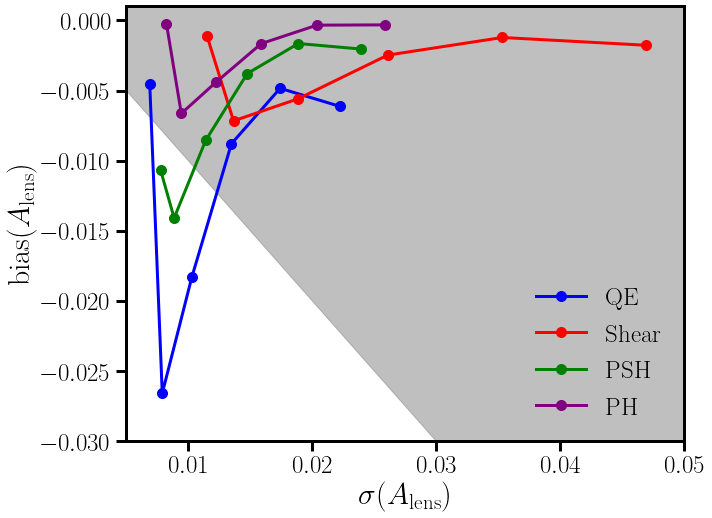

In [83]:
plt.figure(figsize=(10,8))

biases = np.array([biases_00,biases_02,biases_04,biases_06,biases_08,biases_10]).T
noises = np.array([noises_00,noises_02,noises_04,noises_06,noises_08,noises_10]).T

plt.plot(noises[0],biases[0],marker='.',markersize=20,lw=3,c='b',label='QE')
plt.plot(noises[1],biases[1],marker='.',markersize=20,lw=3,c='r',label='Shear')
plt.plot(noises[2],biases[2],marker='.',markersize=20,lw=3,c='g',label='PSH')
plt.plot(noises[3],biases[3],marker='.',markersize=20,lw=3,c='purple',label='PH')

domain = np.linspace(5e-3,5e-2,100)
plt.fill_between(domain,-domain,domain*0+0.005,color='gray',alpha=0.5)

plt.legend(frameon=False)
plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')
plt.xlim(5e-3,5e-2)
plt.ylim(-0.03,0.001)

(0.0, 0.05)

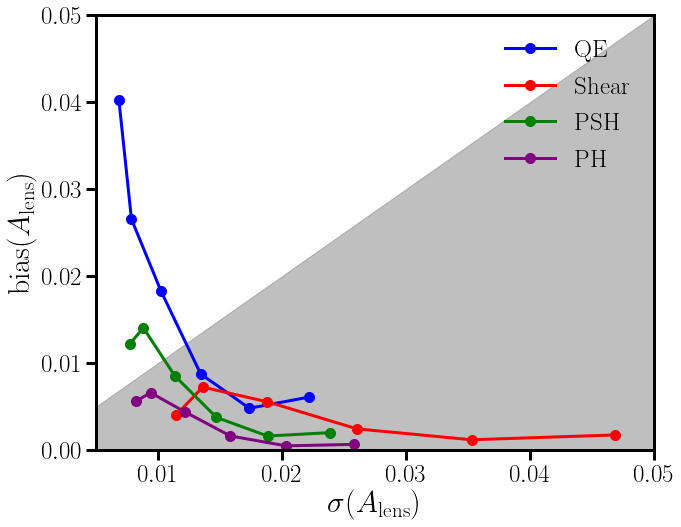

In [38]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T

plt.plot(noises_abs[0],biases_abs[0],marker='.',markersize=20,lw=3,c='b',label='QE')
plt.plot(noises_abs[1],biases_abs[1],marker='.',markersize=20,lw=3,c='r',label='Shear')
plt.plot(noises_abs[2],biases_abs[2],marker='.',markersize=20,lw=3,c='g',label='PSH')
plt.plot(noises_abs[3],biases_abs[3],marker='.',markersize=20,lw=3,c='purple',label='PH')

domain = np.linspace(5e-3,5e-2,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.5)

plt.legend(frameon=False)
plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')
plt.xlim(5e-3,5e-2)
plt.ylim(0,0.05)

(0.95, 10)

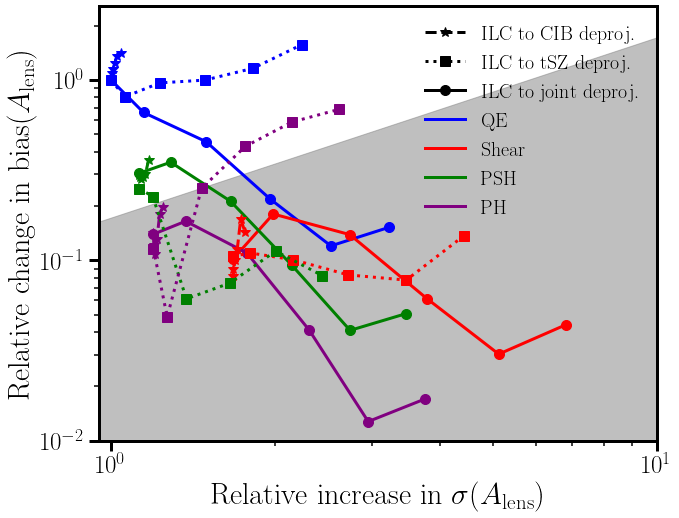

In [118]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T

plt.plot(noises_abs[0]/noises_abs[0][0],biases_abs[0]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='b')
plt.plot(noises_abs[1]/noises_abs[0][0],biases_abs[1]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='r')
plt.plot(noises_abs[2]/noises_abs[0][0],biases_abs[2]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='g')
plt.plot(noises_abs[3]/noises_abs[0][0],biases_abs[3]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='purple')


biases_absa = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_absa = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T

plt.plot(noises_absa[0]/noises_abs[0][0],biases_absa[0]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='b',ls='--')
plt.plot(noises_absa[1]/noises_abs[0][0],biases_absa[1]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='r',ls='--')
plt.plot(noises_absa[2]/noises_abs[0][0],biases_absa[2]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='g',ls='--')
plt.plot(noises_absa[3]/noises_abs[0][0],biases_absa[3]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='purple',ls='--')

biases_absb = np.array([biases_abs_00b,biases_abs_02b,biases_abs_04b,biases_abs_06b,biases_abs_08b,biases_abs_10b]).T
noises_absb = np.array([noises_abs_00b,noises_abs_02b,noises_abs_04b,noises_abs_06b,noises_abs_08b,noises_abs_10b]).T

plt.plot(noises_absb[0]/noises_abs[0][0],biases_absb[0]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='b',ls='dotted')
plt.plot(noises_absb[1]/noises_abs[0][0],biases_absb[1]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='r',ls='dotted')
plt.plot(noises_absb[2]/noises_abs[0][0],biases_absb[2]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='g',ls='dotted')
plt.plot(noises_absb[3]/noises_abs[0][0],biases_absb[3]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='purple',ls='dotted')

plt.plot([],[],c='k',marker='*',markersize=10,lw=3,ls='dashed',label='ILC to CIB deproj.')
plt.plot([],[],c='k',marker='s',markersize=10,lw=3,ls='dotted',label='ILC to tSZ deproj.')
plt.plot([],[],c='k',marker='.',markersize=20,lw=3,label='ILC to joint deproj.')

plt.plot([],[],c='b',lw=3,label='QE')
plt.plot([],[],c='r',lw=3,label='Shear')
plt.plot([],[],c='g',lw=3,label='PSH')
plt.plot([],[],c='purple',lw=3,label='PH')


domain = np.linspace(5e-3,8e-2,100)
plt.fill_between(domain/noises_abs[0][0],domain/biases_abs[0][0],domain*0,color='gray',alpha=0.5)

plt.legend(frameon=False,ncol=1,fontsize=20)
plt.xlabel(r'Relative increase in $\sigma(A_\text{lens})$')
plt.ylabel(r'Relative change in $\text{bias}(A_\text{lens})$')

plt.xscale('log')
plt.yscale('log')




plt.xlim(0.95,10)
#plt.xlim(5e-3,5e-2)
#plt.ylim(0,0.06)

(0.95, 5)

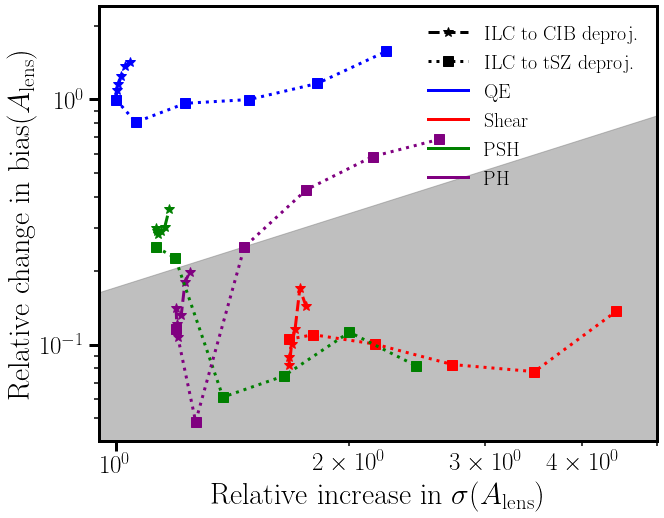

In [121]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T

#plt.plot(noises_abs[0]/noises_abs[0][0],biases_abs[0]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='b')
#plt.plot(noises_abs[1]/noises_abs[0][0],biases_abs[1]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='r')
#plt.plot(noises_abs[2]/noises_abs[0][0],biases_abs[2]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='g')
#plt.plot(noises_abs[3]/noises_abs[0][0],biases_abs[3]/biases_abs[0][0],marker='.',markersize=20,lw=3,c='purple')


biases_absa = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_absa = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T

plt.plot(noises_absa[0]/noises_abs[0][0],biases_absa[0]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='b',ls='--')
plt.plot(noises_absa[1]/noises_abs[0][0],biases_absa[1]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='r',ls='--')
plt.plot(noises_absa[2]/noises_abs[0][0],biases_absa[2]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='g',ls='--')
plt.plot(noises_absa[3]/noises_abs[0][0],biases_absa[3]/biases_abs[0][0],marker='*',markersize=10,lw=3,c='purple',ls='--')

biases_absb = np.array([biases_abs_00b,biases_abs_02b,biases_abs_04b,biases_abs_06b,biases_abs_08b,biases_abs_10b]).T
noises_absb = np.array([noises_abs_00b,noises_abs_02b,noises_abs_04b,noises_abs_06b,noises_abs_08b,noises_abs_10b]).T

plt.plot(noises_absb[0]/noises_abs[0][0],biases_absb[0]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='b',ls='dotted')
plt.plot(noises_absb[1]/noises_abs[0][0],biases_absb[1]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='r',ls='dotted')
plt.plot(noises_absb[2]/noises_abs[0][0],biases_absb[2]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='g',ls='dotted')
plt.plot(noises_absb[3]/noises_abs[0][0],biases_absb[3]/biases_abs[0][0],marker='s',markersize=10,lw=3,c='purple',ls='dotted')

plt.plot([],[],c='k',marker='*',markersize=10,lw=3,ls='dashed',label='ILC to CIB deproj.')
plt.plot([],[],c='k',marker='s',markersize=10,lw=3,ls='dotted',label='ILC to tSZ deproj.')
#plt.plot([],[],c='k',marker='.',markersize=20,lw=3,label='ILC to joint deproj.')

plt.plot([],[],c='b',lw=3,label='QE')
plt.plot([],[],c='r',lw=3,label='Shear')
plt.plot([],[],c='g',lw=3,label='PSH')
plt.plot([],[],c='purple',lw=3,label='PH')


domain = np.linspace(5e-3,8e-2,100)
plt.fill_between(domain/noises_abs[0][0],domain/biases_abs[0][0],domain*0,color='gray',alpha=0.5)

plt.legend(frameon=False,ncol=1,fontsize=20)
plt.xlabel(r'Relative increase in $\sigma(A_\text{lens})$')
plt.ylabel(r'Relative change in $\text{bias}(A_\text{lens})$')

plt.xscale('log')
plt.yscale('log')




plt.xlim(0.95,5)
#plt.xlim(5e-3,5e-2)
#plt.ylim(0,0.06)

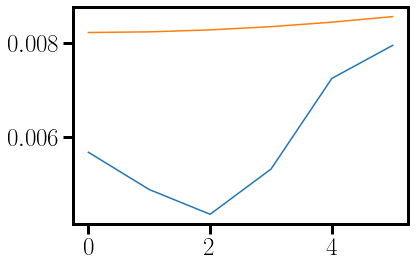

In [126]:
plt.plot(biases_absa[3])
plt.plot(noises_absa[3])

No handles with labels found to put in legend.


(0.0, 0.06)

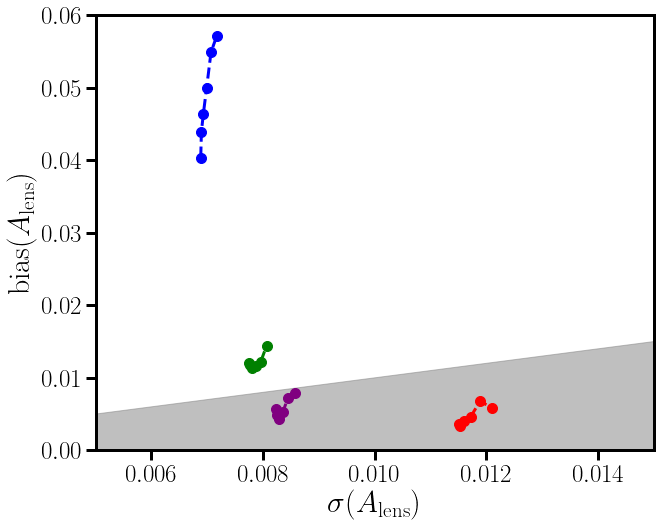

In [68]:
plt.figure(figsize=(10,8))


biases_absa = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_absa = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T

plt.plot(noises_absa[0],biases_absa[0],marker='.',markersize=20,lw=3,c='b',ls='--')
plt.plot(noises_absa[1],biases_absa[1],marker='.',markersize=20,lw=3,c='r',ls='--')
plt.plot(noises_absa[2],biases_absa[2],marker='.',markersize=20,lw=3,c='g',ls='--')
plt.plot(noises_absa[3],biases_absa[3],marker='.',markersize=20,lw=3,c='purple',ls='--')


domain = np.linspace(5e-3,5e-2,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.5)

plt.legend(frameon=False)
plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')
plt.xlim(5e-3,1.5e-2)
plt.ylim(0,0.06)

(0.0, 0.06)

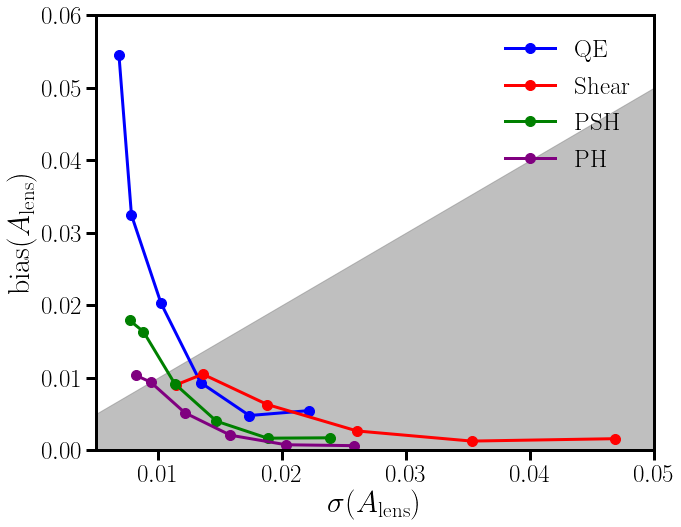

In [126]:
plt.figure(figsize=(10,8))

biases_abs_abs = np.array([biases_abs_abs_00,biases_abs_abs_02,biases_abs_abs_04,biases_abs_abs_06,biases_abs_abs_08,biases_abs_abs_10]).T
noises_abs_abs = np.array([noises_abs_abs_00,noises_abs_abs_02,noises_abs_abs_04,noises_abs_abs_06,noises_abs_abs_08,noises_abs_abs_10]).T

plt.plot(noises_abs_abs[0],biases_abs_abs[0],marker='.',markersize=20,lw=3,c='b',label='QE')
plt.plot(noises_abs_abs[1],biases_abs_abs[1],marker='.',markersize=20,lw=3,c='r',label='Shear')
plt.plot(noises_abs_abs[2],biases_abs_abs[2],marker='.',markersize=20,lw=3,c='g',label='PSH')
plt.plot(noises_abs_abs[3],biases_abs_abs[3],marker='.',markersize=20,lw=3,c='purple',label='PH')

domain = np.linspace(5e-3,5e-2,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.5)

plt.legend(frameon=False)
plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')
plt.xlim(5e-3,5e-2)
plt.ylim(0,0.06)

Text(0, 0.5, 'Loss')

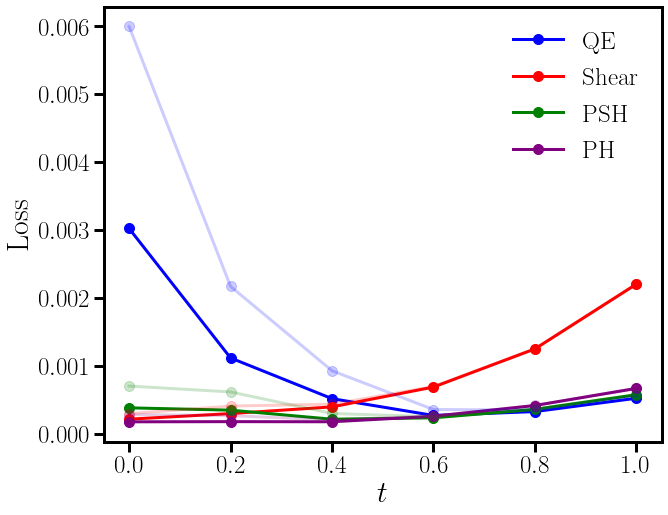

In [122]:
plt.figure(figsize=(10,8))

biases_abs_abs = np.array([biases_abs_abs_00,biases_abs_abs_02,biases_abs_abs_04,biases_abs_abs_06,biases_abs_abs_08,biases_abs_abs_10]).T
noises_abs_abs = np.array([noises_abs_abs_00,noises_abs_abs_02,noises_abs_abs_04,noises_abs_abs_06,noises_abs_abs_08,noises_abs_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])



plt.plot(ts,biases_abs_abs[0]**2+noises_abs_abs[0]**2,marker='.',markersize=20,lw=3,c='b',label='QE')
plt.plot(ts,biases_abs_abs[1]**2+noises_abs_abs[1]**2,marker='.',markersize=20,lw=3,c='r',label='Shear')
plt.plot(ts,biases_abs_abs[2]**2+noises_abs_abs[2]**2,marker='.',markersize=20,lw=3,c='g',label='PSH')
plt.plot(ts,biases_abs_abs[3]**2+noises_abs_abs[3]**2,marker='.',markersize=20,lw=3,c='purple',label='PH')


plt.legend(frameon=False)
plt.xlabel(r'$t$')
plt.ylabel(r'Loss')

In [90]:
plt.figure(figsize=(10,8))

biases_abs_abs = np.array([biases_abs_abs_00,biases_abs_abs_02,biases_abs_abs_04,biases_abs_abs_06,biases_abs_abs_08,biases_abs_abs_10]).T
noises_abs_abs = np.array([noises_abs_abs_00,noises_abs_abs_02,noises_abs_abs_04,noises_abs_abs_06,noises_abs_abs_08,noises_abs_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.1,10,100)

def tstar(i,fb): return ts[np.argmin(fb*biases_abs_abs[i]**2+noises_abs_abs[i]**2)]

plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$t_\star$')

NameError: name 'biases_abs_abs_00' is not defined

<Figure size 720x576 with 0 Axes>

Text(0, 0.5, 'Loss')

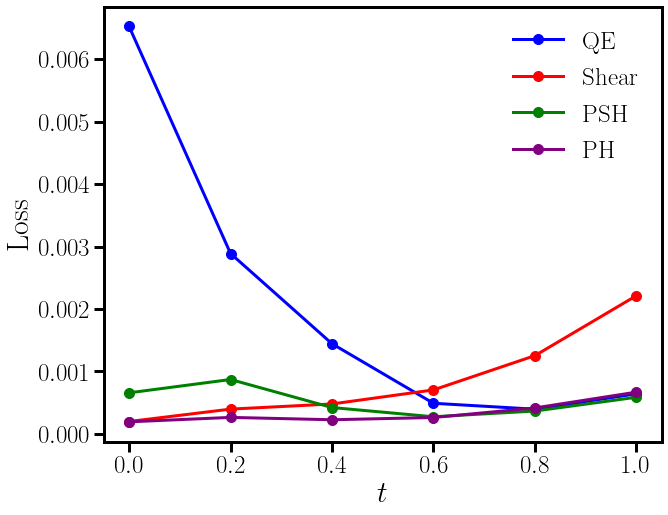

In [108]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])


fb=2
plt.plot(ts,fb**2*biases_abs[0]**2+noises_abs[0]**2,marker='.',markersize=20,lw=3,c='b',label='QE')
plt.plot(ts,fb**2*biases_abs[1]**2+noises_abs[1]**2,marker='.',markersize=20,lw=3,c='r',label='Shear')
plt.plot(ts,fb**2*biases_abs[2]**2+noises_abs[2]**2,marker='.',markersize=20,lw=3,c='g',label='PSH')
plt.plot(ts,fb**2*biases_abs[3]**2+noises_abs[3]**2,marker='.',markersize=20,lw=3,c='purple',label='PH')


plt.legend(frameon=False)
plt.xlabel(r'$t$')
plt.ylabel(r'Loss')

Text(0, 0.5, 'Loss')

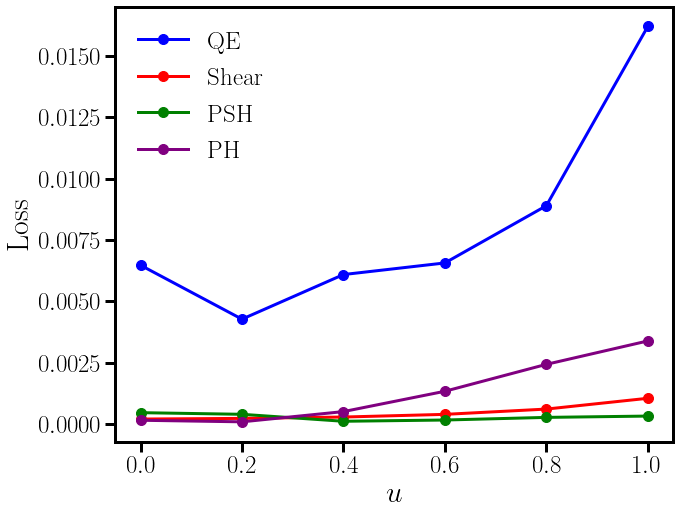

In [107]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00b,biases_abs_02b,biases_abs_04b,biases_abs_06b,biases_abs_08b,biases_abs_10b]).T
noises_abs = np.array([noises_abs_00b,noises_abs_02b,noises_abs_04b,noises_abs_06b,noises_abs_08b,noises_abs_10b]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])


fb=2
plt.plot(ts,fb**2*biases_abs[0]**2+noises_abs[0]**2,marker='.',markersize=20,lw=3,c='b',label='QE')
plt.plot(ts,fb**2*biases_abs[1]**2+noises_abs[1]**2,marker='.',markersize=20,lw=3,c='r',label='Shear')
plt.plot(ts,fb**2*biases_abs[2]**2+noises_abs[2]**2,marker='.',markersize=20,lw=3,c='g',label='PSH')
plt.plot(ts,fb**2*biases_abs[3]**2+noises_abs[3]**2,marker='.',markersize=20,lw=3,c='purple',label='PH')


plt.legend(frameon=False)
plt.xlabel(r'$u$')
plt.ylabel(r'Loss')

Text(0, 0.5, 'Loss')

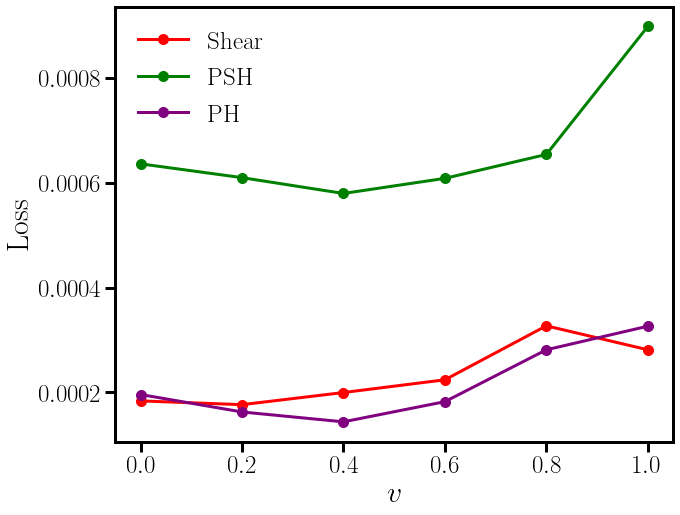

In [106]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_abs = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])


fb=2
#plt.plot(ts,fb**2*biases_abs[0]**2+noises_abs[0]**2,marker='.',markersize=20,lw=3,c='b',label='QE')
plt.plot(ts,fb**2*biases_abs[1]**2+noises_abs[1]**2,marker='.',markersize=20,lw=3,c='r',label='Shear')
plt.plot(ts,fb**2*biases_abs[2]**2+noises_abs[2]**2,marker='.',markersize=20,lw=3,c='g',label='PSH')
plt.plot(ts,fb**2*biases_abs[3]**2+noises_abs[3]**2,marker='.',markersize=20,lw=3,c='purple',label='PH')


plt.legend(frameon=False)
plt.xlabel(r'$v$')
plt.ylabel(r'Loss')

No handles with labels found to put in legend.


Text(0, 0.5, 'Loss')

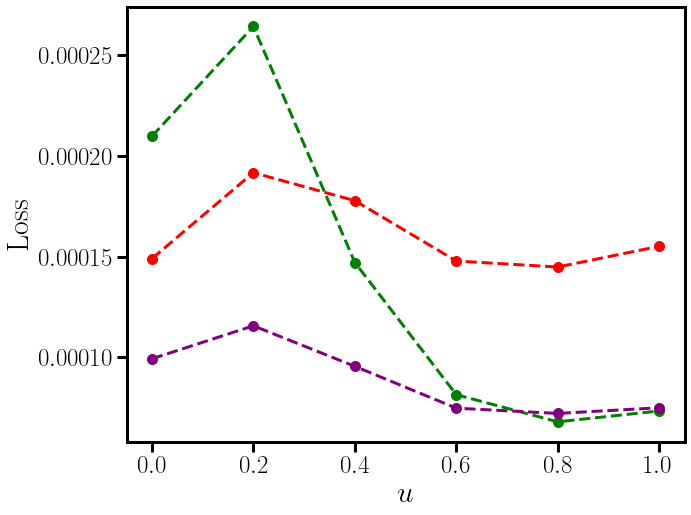

In [62]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])


#plt.plot(ts,biases_absa[0]**2+noises_absa[0]**2,marker='.',markersize=20,lw=3,c='b',ls='--')
plt.plot(ts,biases_absa[1]**2+noises_absa[1]**2,marker='.',markersize=20,lw=3,c='r',ls='--')
plt.plot(ts,biases_absa[2]**2+noises_absa[2]**2,marker='.',markersize=20,lw=3,c='g',ls='--')
plt.plot(ts,biases_absa[3]**2+noises_absa[3]**2,marker='.',markersize=20,lw=3,c='purple',ls='--')


plt.legend(frameon=False)
plt.xlabel(r'$u$')
plt.ylabel(r'Loss')

Text(0, 0.5, '$t_\\star$')

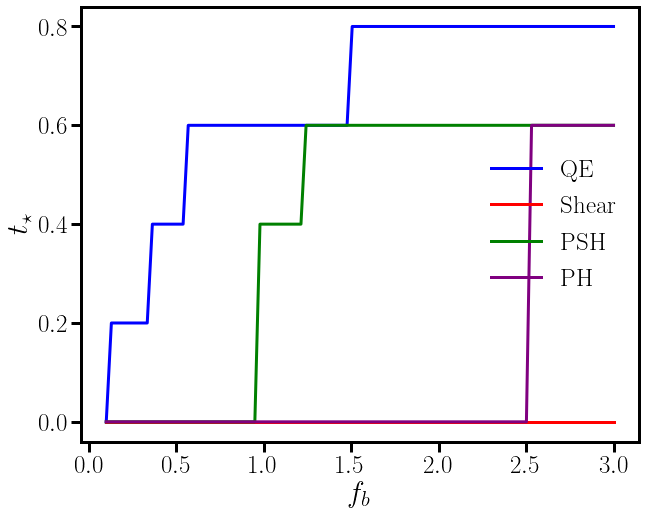

In [94]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.1,3,100)

def tstar(i,fb): return ts[np.argmin(fb**2*biases_abs[i]**2+noises_abs[i]**2)]

plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$t_\star$')

Text(0, 0.5, '$v_\\star$')

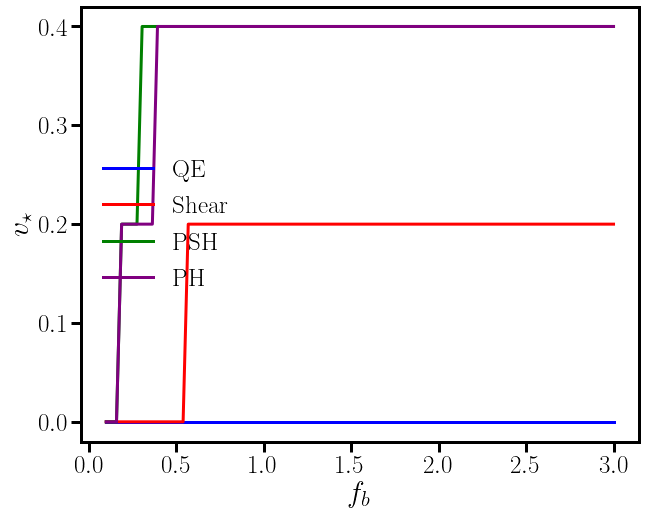

In [101]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_abs = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.1,3,100)

def tstar(i,fb): return ts[np.argmin(fb**2*biases_abs[i]**2+noises_abs[i]**2)]

plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$v_\star$')

Text(0, 0.5, '$u_\\star$')

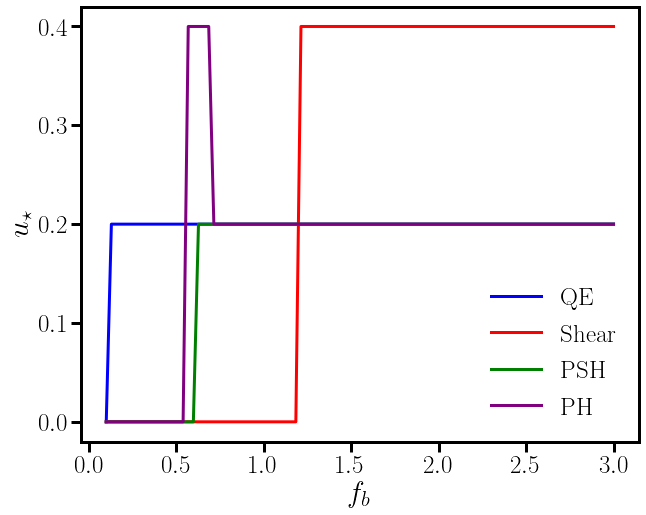

In [102]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00b,biases_abs_02b,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_abs = np.array([noises_abs_00b,noises_abs_02b,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.1,3,100)

def tstar(i,fb): return ts[np.argmin(fb**2*biases_abs[i]**2+noises_abs[i]**2)]

plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$u_\star$')

In [ ]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.1,10,100)

def tstar(i,fb): return ts[np.argmin(fb*biases_abs[i]**2+noises_abs[i]**2)]

plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$t_\star$')

Text(0, 0.5, '$\\mathcal{L}(t_\\star\\,;\\, f_b)$')

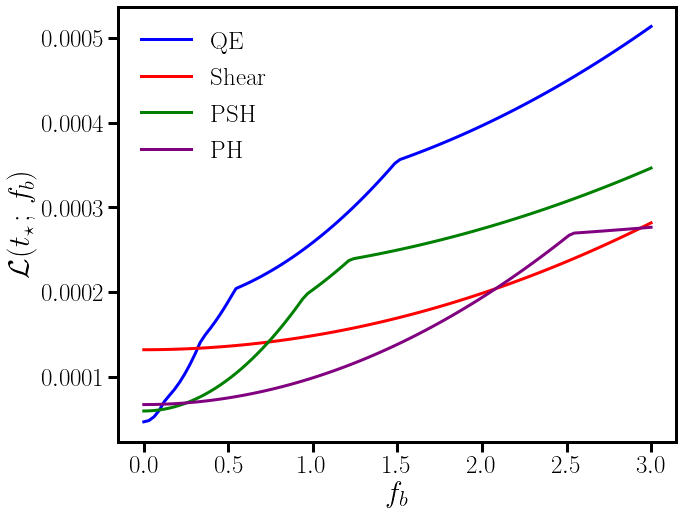

In [131]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.,3,100)

def tstar(i,fb): 
   idx = np.argmin(fb**2*biases_abs[i]**2+noises_abs[i]**2)
   return (fb**2*biases_abs[i]**2+noises_abs[i]**2)[idx]

plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$\mathcal{L}(t_\star\,;\, f_b)$')

Text(0, 0.5, '$\\mathcal{L}(u_\\star\\,;\\, f_b)$')

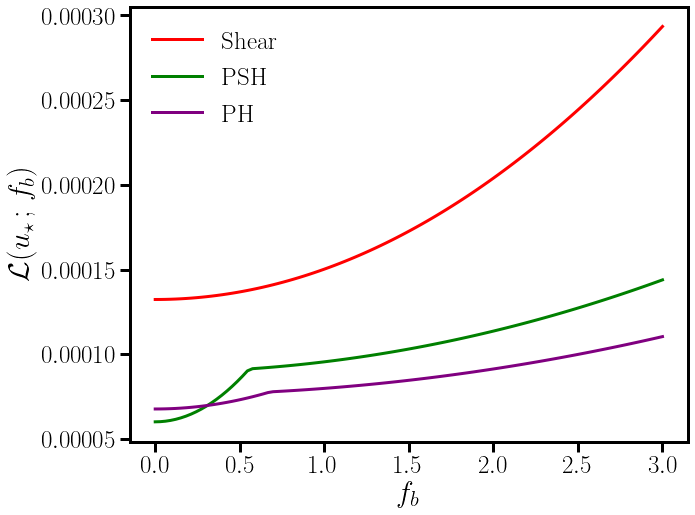

In [111]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00b,biases_abs_02b,biases_abs_04b,biases_abs_06b,biases_abs_08b,biases_abs_10b]).T
noises_abs = np.array([noises_abs_00b,noises_abs_02b,noises_abs_04b,noises_abs_06b,noises_abs_08b,noises_abs_10b]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.,3,100)

def tstar(i,fb): 
   idx = np.argmin(fb**2*biases_abs[i]**2+noises_abs[i]**2)
   return (fb**2*biases_abs[i]**2+noises_abs[i]**2)[idx]

#plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$\mathcal{L}(u_\star\,;\, f_b)$')

Text(0, 0.5, '$\\mathcal{L}(v_\\star\\,;\\, f_b)$')

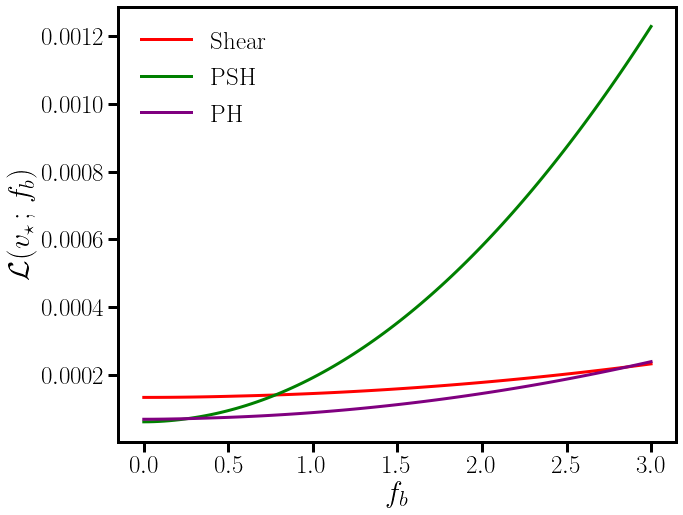

In [129]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_abs = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.,3,100)

def tstar(i,fb): 
   idx = np.argmin(fb**2*biases_abs[i]**2+noises_abs[i]**2)
   return (fb**2*biases_abs[i]**2+noises_abs[i]**2)[idx]

#plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb) for fb in fbs],lw=3,c='purple',label='PH')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$\mathcal{L}(v_\star\,;\, f_b)$')

Text(0, 0.5, '$\\mathcal{L}(X_\\star\\,;\\, f_b)$ where $X = t,u,$ or $v$')

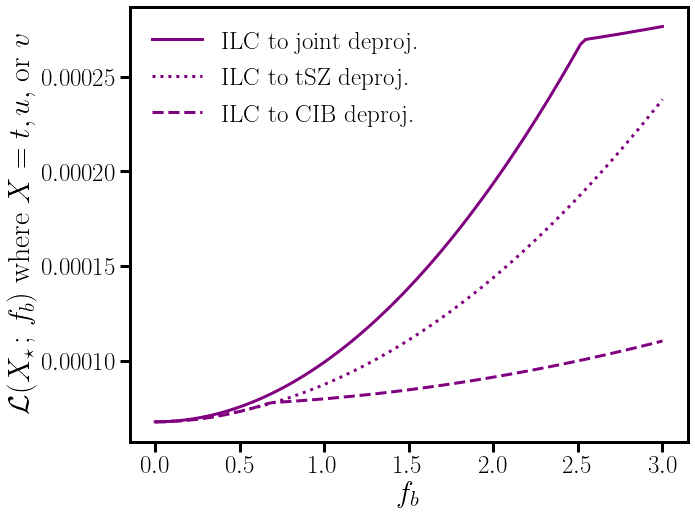

In [120]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T

biases_absa = np.array([biases_abs_00a,biases_abs_02a,biases_abs_04a,biases_abs_06a,biases_abs_08a,biases_abs_10a]).T
noises_absa = np.array([noises_abs_00a,noises_abs_02a,noises_abs_04a,noises_abs_06a,noises_abs_08a,noises_abs_10a]).T

biases_absb = np.array([biases_abs_00b,biases_abs_02b,biases_abs_04b,biases_abs_06b,biases_abs_08b,biases_abs_10b]).T
noises_absb = np.array([noises_abs_00b,noises_abs_02b,noises_abs_04b,noises_abs_06b,noises_abs_08b,noises_abs_10b]).T

ts = np.array([0,0.2,0.4,0.6,0.8,1.0])
fbs = np.linspace(0.,3,100)

def tstar(i,fb): 
   idx = np.argmin(fb**2*biases_abs[i]**2+noises_abs[i]**2)
   L = (fb**2*biases_abs[i]**2+noises_abs[i]**2)[idx]
   idxa = np.argmin(fb**2*biases_absa[i]**2+noises_absa[i]**2)
   La = (fb**2*biases_absa[i]**2+noises_absa[i]**2)[idxa]
   idxb = np.argmin(fb**2*biases_absb[i]**2+noises_absb[i]**2)
   Lb = (fb**2*biases_absb[i]**2+noises_absb[i]**2)[idxb]
   return np.array([L,La,Lb])

#plt.plot(fbs,[tstar(0,fb) for fb in fbs],lw=3,c='b',label='QE')
#plt.plot(fbs,[tstar(1,fb) for fb in fbs],lw=3,c='r',label='Shear')
#plt.plot(fbs,[tstar(2,fb) for fb in fbs],lw=3,c='g',label='PSH')
plt.plot(fbs,[tstar(3,fb)[0] for fb in fbs],lw=3,c='purple',label='ILC to joint deproj.')
plt.plot(fbs,[tstar(3,fb)[1] for fb in fbs],lw=3,c='purple',ls='dotted',label='ILC to tSZ deproj.')
plt.plot(fbs,[tstar(3,fb)[2] for fb in fbs],lw=3,c='purple',ls='dashed',label='ILC to CIB deproj.')

plt.legend(frameon=False)
plt.xlabel(r'$f_b$')
plt.ylabel(r'$\mathcal{L}(X_\star\,;\, f_b)$ where $X = t,u,$ or $v$')

Text(0, 0.5, 'Loss')

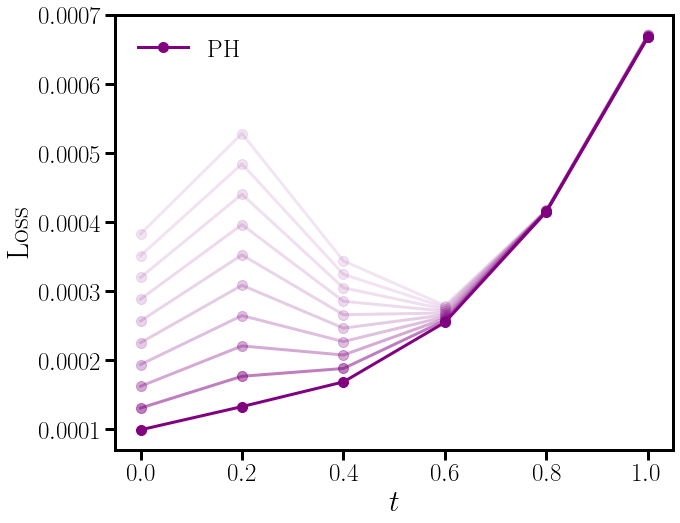

In [109]:
plt.figure(figsize=(10,8))

biases_abs = np.array([biases_abs_00,biases_abs_02,biases_abs_04,biases_abs_06,biases_abs_08,biases_abs_10]).T
noises_abs = np.array([noises_abs_00,noises_abs_02,noises_abs_04,noises_abs_06,noises_abs_08,noises_abs_10]).T
ts = np.array([0,0.2,0.4,0.6,0.8,1.0])




plt.plot(ts,biases_abs[3]**2+noises_abs[3]**2,marker='.',markersize=20,lw=3,c='purple',label='PH')

for fb in range(2,11): plt.plot(ts,fb*biases_abs[3]**2+noises_abs[3]**2,marker='.',markersize=20,lw=3,c='purple',alpha=1/fb)


plt.legend(frameon=False)
plt.xlabel(r'$t$')
plt.ylabel(r'Loss')

In [6]:
mode=2 # goal sensitivity
fsky=0.4
N_LF=1.
N_MF=4.
N_UHF=2.
ellmax=1e4
ell, N_ell_LA_T,N_ell_LA_Pol,WN_levels = Simons_Observatory_V3_LA_noise(mode,fsky,ellmax,1,N_LF,N_MF,N_UHF)

In [7]:
cmb = []

for i in range(nBands):
   cmb.append(CMB(beam=Beam[i], noise=Noise[i], nu1=Nu[i], nu2=Nu[i], lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=True, fg=True))
   forCtotal = lambda l: cmb[i].ftotalTT(l)
   # reinterpolate: gain factor 10 in speed
   L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
   F = np.array(list(map(forCtotal, L)))
   cmb[i].fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

cmb = np.array(cmb)

/home/noah/documents/Documents/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/documents/Documents/Berkeley/LensQuEst-1/cmb.py:127: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/documents/Documents/Berkeley/LensQuEst-1/cmb.py:135: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/documents/Documents/Berkeley/LensQuEst-1/cmb.py:149: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl


In [11]:
wA_tsz = weightsIlcCmb_jointDeproj[:,0]*cmbIlc.cmb[0,0].tszFreqDpdceT(Nu[0])
for i in range(1,6): wA_tsz += weightsIlcCmb_jointDeproj[:,i]*cmbIlc.cmb[0,0].tszFreqDpdceT(Nu[i])

wA_cib = weightsIlcCmb_jointDeproj[:,0]*cmbIlc.cmb[0,0].cibPoissonFreqDpdceT(Nu[0])/1e24
for i in range(1,6): wA_cib += weightsIlcCmb_jointDeproj[:,i]*cmbIlc.cmb[0,0].cibPoissonFreqDpdceT(Nu[i])/1e24

In [12]:
wA_tsz2 = weightsIlcCmb_tszdeproj[:,0]*cmbIlc.cmb[0,0].tszFreqDpdceT(Nu[0])
for i in range(1,6): wA_tsz2 += weightsIlcCmb_tszdeproj[:,i]*cmbIlc.cmb[0,0].tszFreqDpdceT(Nu[i])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


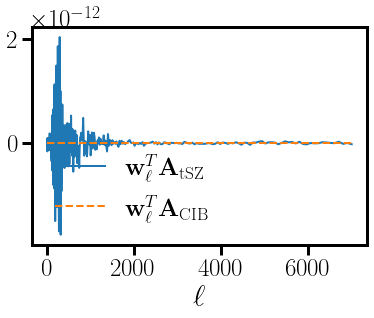

In [13]:
plt.plot(L,wA_tsz,label=r'$\textbf{w}_\ell^T \textbf{A}_\text{tSZ}$',lw=2)
plt.plot(L,wA_cib,ls='--',label=r'$\textbf{w}_\ell^T \textbf{A}_\text{CIB}$',lw=2)
#plt.ylim(-1e-8,1e-8)
plt.legend(loc='lower left',frameon=False)
plt.xlabel(r'$\ell$')
plt.savefig('figures/CIB_deprojection_doesnt_work.pdf',bbox_inches='tight')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


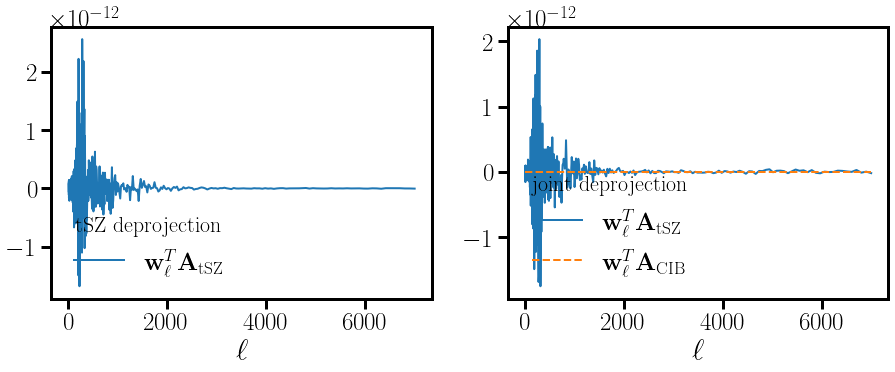

In [14]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(L,wA_tsz2,label=r'$\textbf{w}_\ell^T \textbf{A}_\text{tSZ}$',lw=2)

ax[1].plot(L,wA_tsz,label=r'$\textbf{w}_\ell^T \textbf{A}_\text{tSZ}$',lw=2)
ax[1].plot(L,wA_cib,ls='--',label=r'$\textbf{w}_\ell^T \textbf{A}_\text{CIB}$',lw=2)


ax[0].legend(loc='lower left',frameon=False,title='tSZ deprojection')
ax[0].set_xlabel('$\ell$')

ax[1].legend(loc='lower left',frameon=False,title='joint deprojection')
ax[1].set_xlabel('$\ell$')

plt.savefig('figures/CIB_deprojection_doesnt_work.pdf',bbox_inches='tight')

/home/noah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/home/noah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/home/noah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/home/noah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/home/noah/anaconda3/lib/python3.6/site-packages/ipy

Text(0.5, 1.0, 'Noise from detectors and the atmosphere\n(dashed lines from SO noise calculator)')

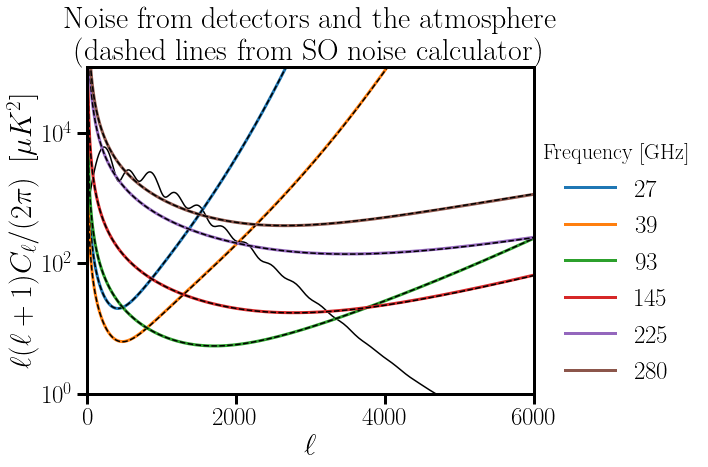

In [15]:
plt.figure(figsize=(8,6))

signal = np.array([cmbIlc.cmb[0,0].flensedTT(l) for l in L])
    
plt.semilogy(L,signal*L*(L+1)/(2.*np.pi),color='k')

for i in range(6): 
   plt.semilogy(L,np.array([cmbIlc.cmb[i,i].fatmosphericNoiseTT(l)+cmbIlc.cmb[i,i].fdetectorNoise(l) for l in L])*L*(L+1)/(2.*np.pi),label=str(int(Nu[i]/1e9)),C='C'+str(i),lw=3)
   #plt.semilogy(L,np.array([cmbIlc.cmb[i,i].ftotalTT(l) for l in L])*L*(L+1)/(2.*np.pi),label=str(int(Nu[i]/1e9)),C='C'+str(i),lw=3)
   plt.semilogy(ell,N_ell_LA_T[i]*ell*(ell+1)/(2.*np.pi),C='k',ls='--')
    
plt.ylim(1,1e5)
plt.xlim(0,6000)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)\,\,\,[\mu K^2]$')
plt.legend(loc=(1,0),frameon=False,title='Frequency [GHz]')
plt.title('Noise from detectors and the atmosphere\n(dashed lines from SO noise calculator)')

In [16]:
print('tSZ:',cmbIlc.cmb[3,3].ftSZ(3000)*3000*3001/2/np.pi)
print('kSZ:',cmbIlc.cmb[3,3].fkSZ(3000)*3000*3001/2/np.pi)
print('CIB Poisson:',cmbIlc.cmb[3,3].fCIBPoisson(3000)*3000*3001/2/np.pi)
print('radio:',cmbIlc.cmb[3,3].fradioPoisson(3000)*3000*3001/2/np.pi)
print('CIB Custered:',cmbIlc.cmb[3,3].fCIBClustered(3000)*3000*3001/2/np.pi)
print('Galactic dust:',cmbIlc.cmb[3,3].fgalacticDust(3000)*3000*3001/2/np.pi)

tSZ: 4.3118533324347625
kSZ: 1.5857573600276216
CIB Poisson: 6.437295303468332
radio: 3.4030746931196005
CIB Custered: 5.241797604252785
Galactic dust: 0.6242538242895379


# Standard QE

In [20]:
def NqCmb(epsilon):  
   #fCtotal =  lambda l: ctot(weights,l)
   fCtotal = np.array([ctot(epsilon,l,lindex) for lindex,l in enumerate(L)])
   interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
   return baseMap.forecastN0Kappa(cmb[0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)(lCen)

In [21]:
NqCmb = NqCmb(np.zeros(6))

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


In [22]:
def NqCmb_JointDeproj(epsilon):  
   #fCtotal =  lambda l: ctot(weights,l)
   fCtotal = np.array([ctot_deproj(l,lindex) for lindex,l in enumerate(L)])
   interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
   return baseMap.forecastN0Kappa(cmb[0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)(lCen)

In [19]:
def fun_e(i):
   result = np.zeros(6)
   result[i] = 0.01
   return result

def fun_e2(i,j):
   result = np.zeros(6)
   result[i] = 0.01
   result[j] = 0.01
   if i == j: result[i] = 0.02
   return result

print('calculating ILC noise')
n0 = NqCmb(np.zeros(6))

normal_points = np.array([None]*6)
matrix_points = np.array([[None]*6]*6)

print('calculating normal points')
for i in range(6): normal_points[i] = NqCmb(fun_e(i))

print('calculating off-diagonal points')
for i in range(6):
   for j in range(i+1):
      matrix_points[i,j] = NqCmb(fun_e2(i,j))

hessian = np.array([[None]*6]*6)
der = np.array([None]*6)
for i in range(6):
   for j in range(i+1):    
      hessian[i,j] = matrix_points[i,j] - normal_points[i] - normal_points[j] + n0
      hessian[i,j] /= 0.01**2.

for i in range(6): 
   der[i] = normal_points[i]-n0
   der[i] /= 0.01

def NqCmb_interp(epsilon):
   result = n0.copy()
   for i in range(6): 
      result += 0.5 * hessian[i,i] * epsilon[i]**2.
      result += der[i] * epsilon[i]
   for i in range(6):
      for j in range(i):
         result += hessian[i,j] * epsilon[i] * epsilon[j]
   return result

calculating ILC noise
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


calculating normal points
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
calculating off-diagonal points
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing th

/home/noah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract
/home/noah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in subtract


computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/documents/Documents/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


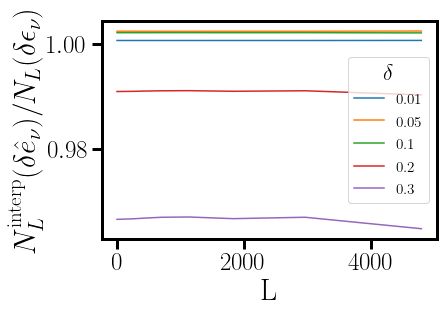

In [21]:
deltas = np.array([0.01,0.05,0.1,0.2,0.3])
for d in deltas: 
   ep = fun_e(2)*d/0.01
   plt.plot(lCen,NqCmb_interp(ep)/NqCmb(ep),label=str(d))

plt.legend(loc=0,fontsize='x-small',title=r'$\delta$')
plt.xlabel('L')
plt.ylabel(r'$N^\text{interp}_L(\delta\hat{e}_\nu)/N_L(\delta \epsilon_\nu)$')
plt.savefig('figures/noise_interp_ratio_QE.pdf',bbox_inches='tight')

In [138]:
def loss(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 =  2. * (ClkCmb + NqCmb_interp(epsilon))**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum(np.abs(2.*np.array(data['QE primary, CIB'])[I]*Cib_scalefactor**2.+2.*np.array(data['QE secondary, CIB'])[I]*Cib_scalefactor**2.+np.array(data['QE trispectrum, CIB'])[I]*Cib_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Tsz = np.sum(np.abs(2.*np.array(data['QE primary, tSZ'])[I]*Tsz_scalefactor**2.+2.*np.array(data['QE secondary, tSZ'])[I]*Tsz_scalefactor**2.+np.array(data['QE trispectrum, tSZ'])[I]*Tsz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Ksz = np.sum(np.abs(2.*np.array(data['QE primary, kSZ'])[I]*Ksz_scalefactor**2.+2.*np.array(data['QE secondary, kSZ'])[I]*Ksz_scalefactor**2.+np.array(data['QE trispectrum, kSZ'])[I]*Ksz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Radiops = np.sum(np.abs(2.*np.array(data['QE primary, Radio PS'])[I]*Radiops_scalefactor**2.+2.*np.array(data['QE secondary, Radio PS'])[I]*Radiops_scalefactor**2.+np.array(data['QE trispectrum, Radio PS'])[I]*Radiops_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm

   bias = Cib**2. + Tsz**2. + Ksz**2. + Radiops**2.
   return np.log(noise + fb*bias)*1.e5


def loss_cross(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 = ((ClkCmb + NqCmb_interp(epsilon))*Cgg + (Ckg)**2) / Nmodes
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum(np.abs(np.array(datax['QE: CIB'])[I]*Cib_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Tsz = np.sum(np.abs(np.array(datax['QE: tSZ'])[I]*Tsz_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Ksz = np.sum(np.abs(np.array(datax['QE: kSZ'])[I]*Ksz_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Radiops = np.sum(np.abs(np.array(datax['QE: Radio PS'])[I]*Radiops_scalefactor**2.) * Ckg[I] / s2[I]) / norm

   bias = Cib**2. + Tsz**2. + Ksz**2. + Radiops**2.
   return np.log(noise + fb*bias)*1.e5

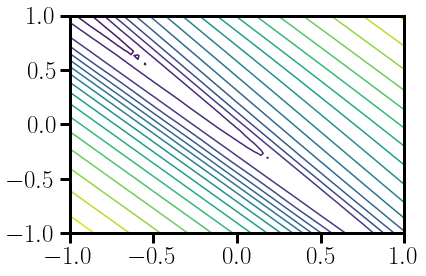

In [148]:
################################################################
xs = np.linspace(-1,1,50)
ys = np.linspace(-1,1,50)

zs = np.zeros((len(xs),len(xs)))

for i,x in enumerate(xs):
   for j,y in enumerate(ys): 
      zs[i,j] = loss([0,y,x,0],fb=1)/1e5
        
X, Y = np.meshgrid(xs, ys)

plt.contour(X, Y, zs,20)

In [139]:
fbs = np.logspace(-4,1,300)
#fbs = np.linspace(1e-4,10,300)

In [149]:
result = []
for i,fb in enumerate(fbs):
   print(i+1,'out of',len(fbs),end='\r')
   #if len(result) == 0.: epsilon = scipy.optimize.minimize(loss,np.array([0.]*(nBands-2)),args=(fb),method='SLSQP') 
   #else: epsilon = scipy.optimize.minimize(loss,result[-1],args=(fb),method='SLSQP')
   if i == 0: epsilon = scipy.optimize.differential_evolution(loss,[(-4,4),(-4,4),(-4,4),(-4,4)],args=(np.array([fb]))) 
   else: 
      old = result[-1]
      eps = 2
      epsilon = scipy.optimize.differential_evolution(loss,[(0,4),(-4,0),(0,4),(0,4)],args=(np.array([fb]))) 
   #epsilon = scipy.optimize.differential_evolution(loss_cross,[(-4,4),(-4,4),(-4,4),(-4,4)],args=(np.array([fb]))) 
   result.append(epsilon.x)
   
epsilons = np.zeros((len(result),nBands))
for i in range(len(result)):
   for j in range(nBands):
      if j == 0: epsilons[i,j]=0.
      elif j < nBands - 1: epsilons[i,j] = np.array(result)[i,j-1]
      elif j == nBands - 1: epsilons[i,j] = -sum(np.array(result)[i,:])
epsilonT = np.transpose(epsilons)

/home/noah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  app.launch_new_instance()


(5.623413251903491e-05, 5)

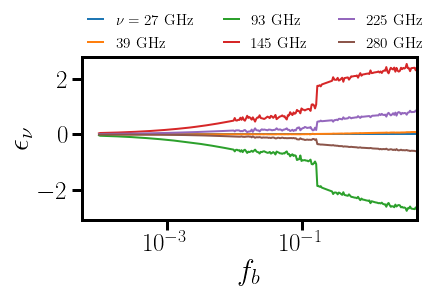

In [150]:
plt.figure(figsize=(6,3))
Nu = np.array([27.e9,39.e9,93.e9,145.e9,225.e9,280.e9])
from headers import*
ILC_deproj = cmbIlc.weightsDeprojTszCIB(3000) - cmbIlc.weightsIlcCmb(3000)

plt.semilogx(fbs,epsilonT[0],color='C0',lw=2,label=r'$\nu = 27$ GHz')
plt.semilogx(fbs,epsilonT[1],color='C1',lw=2,label='39 GHz')
plt.semilogx(fbs,epsilonT[2],color='C2',lw=2,label='93 GHz')
plt.semilogx(fbs,epsilonT[3],color='C3',lw=2,label='145 GHz')
plt.semilogx(fbs,epsilonT[4],color='C4',lw=2,label='225 GHz')
plt.semilogx(fbs,epsilonT[5],color='C5',lw=2,label='280 GHz')

plt.ylabel(r'$\epsilon_\nu$')
plt.legend(loc=(0,1),frameon=False,fontsize='x-small',ncol=3,handlelength=1)
plt.xlabel(r'$f_b$')
plt.xlim(0,5)

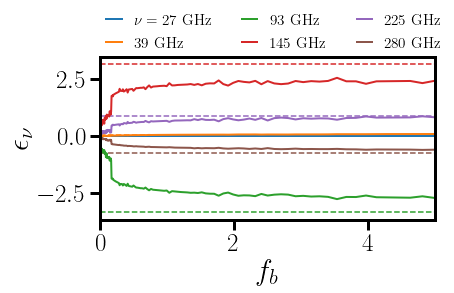

In [151]:
plt.figure(figsize=(6,3))
Nu = np.array([27.e9,39.e9,93.e9,145.e9,225.e9,280.e9])
from headers import*
ILC_deproj = cmbIlc.weightsDeprojTszCIB(3000) - cmbIlc.weightsIlcCmb(3000)
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[0],color='C0',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[1],color='C1',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[2],color='C2',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[3],color='C3',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[4],color='C4',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[5],color='C5',ls='--')

plt.plot(fbs,epsilonT[0],color='C0',lw=2,label=r'$\nu = 27$ GHz')
plt.plot(fbs,epsilonT[1],color='C1',lw=2,label='39 GHz')
plt.plot(fbs,epsilonT[2],color='C2',lw=2,label='93 GHz')
plt.plot(fbs,epsilonT[3],color='C3',lw=2,label='145 GHz')
plt.plot(fbs,epsilonT[4],color='C4',lw=2,label='225 GHz')
plt.plot(fbs,epsilonT[5],color='C5',lw=2,label='280 GHz')

plt.ylabel(r'$\epsilon_\nu$')
plt.legend(loc=(0,1),frameon=False,fontsize='x-small',ncol=3,handlelength=1)
plt.xlabel(r'$f_b$')
plt.xlim(0,5)
plt.savefig('figures/epsilon_vs_fb_SLSQP_QE.pdf',bbox_inches='tight')

In [153]:
def bias_to_alens(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 =  2. * (ClkCmb + NqCmb_interp(epsilon))**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum((2.*np.array(data['QE primary, CIB'])[I]*Cib_scalefactor**2.+2.*np.array(data['QE secondary, CIB'])[I]*Cib_scalefactor**2.+np.array(data['QE trispectrum, CIB'])[I]*Cib_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Tsz = np.sum((2.*np.array(data['QE primary, tSZ'])[I]*Tsz_scalefactor**2.+2.*np.array(data['QE secondary, tSZ'])[I]*Tsz_scalefactor**2.+np.array(data['QE trispectrum, tSZ'])[I]*Tsz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Ksz = np.sum((2.*np.array(data['QE primary, kSZ'])[I]*Ksz_scalefactor**2.+2.*np.array(data['QE secondary, kSZ'])[I]*Ksz_scalefactor**2.+np.array(data['QE trispectrum, kSZ'])[I]*Ksz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Radiops = np.sum((2.*np.array(data['QE primary, Radio PS'])[I]*Radiops_scalefactor**2.+2.*np.array(data['QE secondary, Radio PS'])[I]*Radiops_scalefactor**2.+np.array(data['QE trispectrum, Radio PS'])[I]*Radiops_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm

   return np.array([Cib,Tsz,Ksz,Radiops,np.sqrt(noise)])


def bias_to_alensx(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 = ((ClkCmb + NqCmb_interp(epsilon))*Cgg + (Ckg)**2) / Nmodes
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum(np.array(datax['QE: CIB'])[I]*Cib_scalefactor**2. * Ckg[I] / s2[I]) / norm
   #
   Tsz = np.sum(np.array(datax['QE: tSZ'])[I]*Tsz_scalefactor**2. * Ckg[I] / s2[I]) / norm
   #
   Ksz = np.sum(np.array(datax['QE: kSZ'])[I]*Ksz_scalefactor**2. * Ckg[I] / s2[I]) / norm
   #
   Radiops = np.sum(np.array(datax['QE: Radio PS'])[I]*Radiops_scalefactor**2. * Ckg[I] / s2[I]) / norm

   return np.array([Cib,Tsz,Ksz,Radiops,np.sqrt(noise)])

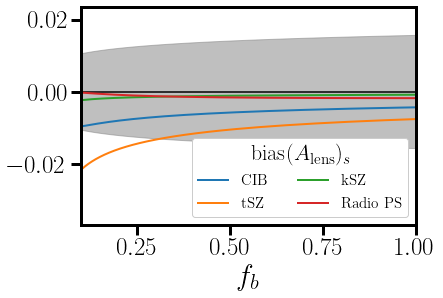

In [29]:
plt.axhline(0,-10,10,color='k')  
plt.fill_between(fbs,[-bias_to_alens(peps)[4] for peps in result],\
[bias_to_alens(peps)[4] for peps in result],color='gray',alpha=0.5)
plt.plot(fbs,[bias_to_alens(peps)[0] for peps in result],label='CIB',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[1] for peps in result],label='tSZ',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[2] for peps in result],label='kSZ',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[3] for peps in result],label='Radio PS',lw=2)
plt.legend(loc=0,frameon=True,framealpha=1,fontsize='x-small',ncol=2,\
           title=r'$\text{bias}(A_\text{lens})_s$')
plt.xlabel(r'$f_b$')
plt.xlim(0.1,1)
plt.savefig('figures/prim_bias_and_noise_vs_fb_QE.pdf',bbox_inches='tight')

In [30]:
biases_QEx = np.array([bias_to_alensx(peps) for peps in result])

In [157]:
ts = np.linspace(0,1,101)
diff = cmbIlc.weightsDeprojTszCIB(3000) - cmbIlc.weightsIlcCmb(3000)
dumb_weights = np.array([t*diff for t in ts])
dumb_peps = dumb_weights[:,1:5]

In [158]:
biases_dumb = np.array([bias_to_alens(peps+np.array([0.00,0.00,0,0])) for peps in dumb_peps])

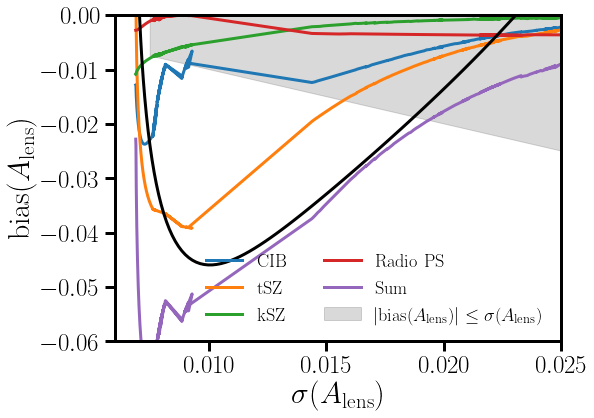

In [168]:
fig,ax = plt.subplots(figsize=(8,6))

biases_QE = np.array([bias_to_alens(peps) for peps in result])

#plt.axhline(0,-10,10,color='k')  
ax.plot(biases_QE[:,4],biases_QE[:,0],lw=3,label='CIB')
ax.plot(biases_QE[:,4],biases_QE[:,1],lw=3,label='tSZ')
ax.plot(biases_QE[:,4],biases_QE[:,2],lw=3,label='kSZ')
ax.plot(biases_QE[:,4],biases_QE[:,3],lw=3,label='Radio PS')
ax.plot(biases_QE[:,4],biases_QE[:,0]+biases_QE[:,1]+biases_QE[:,2]+biases_QE[:,3],lw=3,label='Sum')
ax.plot(biases_dumb[:,4],biases_dumb[:,0]+biases_dumb[:,1]+biases_dumb[:,2]+biases_dumb[:,3],lw=3,c='k')

x = np.linspace(0.008,0.02,10)
#plt.plot(x,-x,c='k',ls='--',label=r'$|\text{bias}(A_\text{lens})| = \sigma(A_\text{lens})$')


x = np.linspace(0.0075,0.25,10)
plt.fill_between(x,-x,np.zeros(x.shape),color='k',alpha=0.15,label=r'$|\text{bias}(A_\text{lens})| \leq \sigma(A_\text{lens})$')
#plt.text(0.0081,-0.0055,r'$|\text{bias}(A_\text{lens})| \leq \sigma(A_\text{lens})$')

ax.legend(loc=0,frameon=False,framealpha=1,fontsize='small',ncol=2)
#ax.set_xlim(0.01,0.02)
ax.set_xlabel(r'$\sigma(A_\text{lens})$')
ax.set_ylabel(r'$\text{bias}(A_\text{lens})$')

fbVnoise_interp = interp1d([bias_to_alens(peps)[4] for peps in result],fbs, kind='linear', bounds_error=False, fill_value=0.)



plt.xlim(0.006,0.025)
plt.ylim(-0.06,0)


plt.savefig('figures/bias_vs_noise_QE.png',bbox_inches='tight')

Text(0, 0.5, '$\\text{bias}(A_\\text{lens})$')

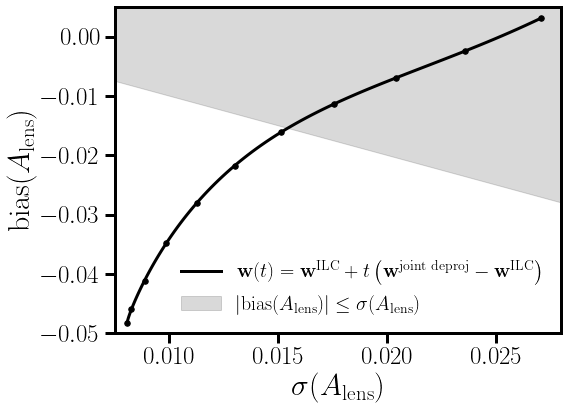

In [40]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(biases_dumb[:,4],biases_dumb[:,0]+biases_dumb[:,1]+biases_dumb[:,2]+biases_dumb[:,3],lw=3,c='k',
        label=r'$\textbf{w}(t)=\textbf{w}^\text{ILC} + t\left(\textbf{w}^\text{joint deproj}-\textbf{w}^\text{ILC}\right)$')

ax.scatter(biases_dumb[:,4][[0,10,20,30,40,50,60,70,80,90,100]],(biases_dumb[:,0]+biases_dumb[:,1]+biases_dumb[:,2]+biases_dumb[:,3])[[0,10,20,30,40,50,60,70,80,90,100]],c='k',s=30)

x = np.linspace(0.0075,0.2,10)
plt.fill_between(x,-x,np.ones(x.shape),color='k',alpha=0.15,label=r'$|\text{bias}(A_\text{lens})| \leq \sigma(A_\text{lens})$')

plt.xlim(0.0075,0.028)
plt.ylim(-0.05,0.005)


plt.legend(loc='lower right',frameon=False,fontsize=20)
ax.set_xlabel(r'$\sigma(A_\text{lens})$')
ax.set_ylabel(r'$\text{bias}(A_\text{lens})$')

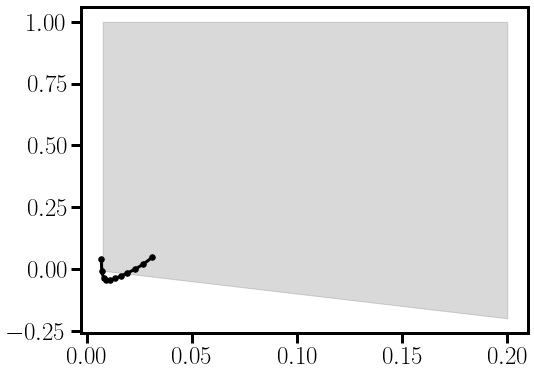

In [165]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(biases_dumb[:,4],biases_dumb[:,0]+biases_dumb[:,1]+biases_dumb[:,2]+biases_dumb[:,3],lw=3,c='k',
        label=r'$\textbf{w}(t)=\textbf{w}^\text{ILC} + t\left(\textbf{w}^\text{joint deproj}-\textbf{w}^\text{ILC}\right)$')

ax.scatter(biases_dumb[:,4][[0,10,20,30,40,50,60,70,80,90,100]],(biases_dumb[:,0]+biases_dumb[:,1]+biases_dumb[:,2]+biases_dumb[:,3])[[0,10,20,30,40,50,60,70,80,90,100]],c='k',s=30)

x = np.linspace(0.0075,0.2,10)
plt.fill_between(x,-x,np.ones(x.shape),color='k',alpha=0.15,label=r'$|\text{bias}(A_\text{lens})| \leq \sigma(A_\text{lens})$')

#plt.xlim(0.008,0.0084)
#plt.ylim(-0.049,-0.045)

#ax.set_xlabel(r'$\sigma(A_\text{lens})$')
#ax.set_ylabel(r'$\text{bias}(A_\text{lens})$')

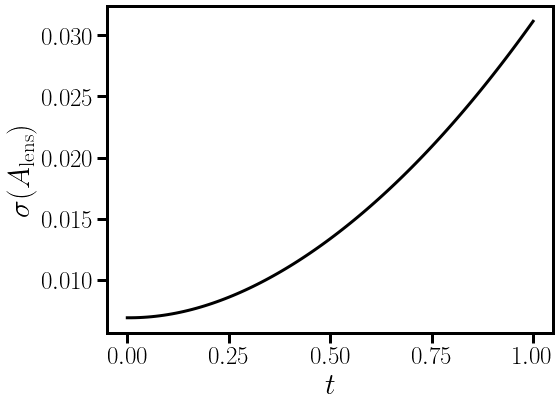

In [163]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(ts,biases_dumb[:,4],lw=3,c='k')

ax.set_ylabel(r'$\sigma(A_\text{lens})$')
ax.set_xlabel(r'$t$')
plt.savefig('figures/noise_vs_t.pdf',bbox_inches='tight')

No handles with labels found to put in legend.


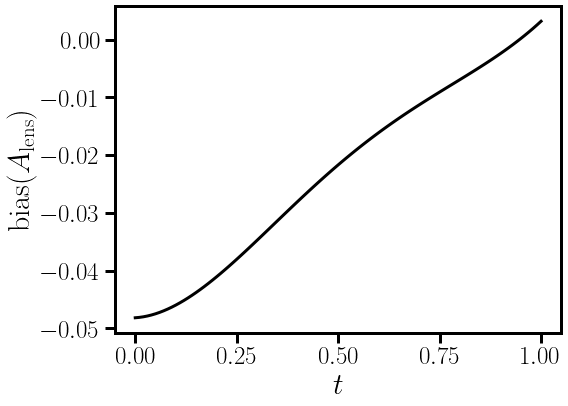

In [45]:
fig,ax = plt.subplots(figsize=(8,6))

#ax.plot(ts,biases_dumb[:,0],lw=3,label='CIB')
#ax.plot(ts,biases_dumb[:,1],lw=3,label='tSZ')
#ax.plot(ts,biases_dumb[:,2],lw=3,label='kSZ')
#ax.plot(ts,biases_dumb[:,3],lw=3,label='Radio PS')
ax.plot(ts,biases_dumb[:,0]+biases_dumb[:,1]+biases_dumb[:,2]+biases_dumb[:,3],lw=3,c='k')


ax.legend(loc='lower right',frameon=False)
ax.set_ylabel(r'$\text{bias}(A_\text{lens})$')
ax.set_xlabel(r'$t$')
plt.savefig('figures/bias_vs_t.pdf',bbox_inches='tight')

/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] n

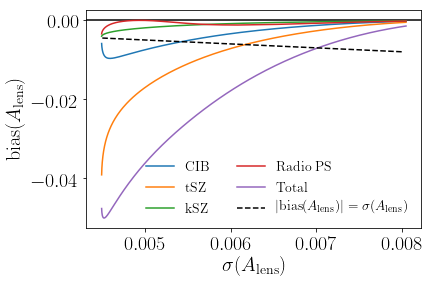

In [32]:
fig,ax = plt.subplots()

biases_QE = np.array([bias_to_alens(peps) for peps in result])

plt.axhline(0,-10,10,color='k')  
ax.plot(biases_QEx[:,4],biases_QEx[:,0],label='CIB')
ax.plot(biases_QEx[:,4],biases_QEx[:,1],label='tSZ')
ax.plot(biases_QEx[:,4],biases_QEx[:,2],label='kSZ')
ax.plot(biases_QEx[:,4],biases_QEx[:,3],label='Radio PS')
ax.plot(biases_QEx[:,4],biases_QEx[:,0]+biases_QE[:,1]+biases_QE[:,2]+biases_QE[:,3],label='Total')

x = np.linspace(0.0045,0.008,10)
plt.plot(x,-x,c='k',ls='--',label=r'$|\text{bias}(A_\text{lens})| = \sigma(A_\text{lens})$')

ax.legend(loc=0,frameon=False,framealpha=1,fontsize='x-small',ncol=2)
#ax.set_xlim(0.01,0.02)
ax.set_xlabel(r'$\sigma(A_\text{lens})$')
ax.set_ylabel(r'$\text{bias}(A_\text{lens})$')

#fbVnoise_interp = interp1d([bias_to_alensx(peps)[4] for peps in result],fbs, kind='linear', bounds_error=False, fill_value=0.)

#secax = ax.twiny()

#new_tick_locations = np.array([.01, .012, .014, .016, 0.018, 0.02])

#secax.set_xlim(ax.get_xlim())
#secax.set_xticks(new_tick_locations)
#secax.set_xticklabels(np.round(fbVnoise_interp(new_tick_locations),2))
#secax.set_xlabel(r'$f_b$')



plt.savefig('figures/bias_vs_noise_QE.png',bbox_inches='tight')

# Shear

In [40]:
##########################################################################################################################
## Shear

def NqCmb(epsilon):  
   fCtotal = np.array([ctot(epsilon,l,lindex) for lindex,l in enumerate(L)])
   interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
   return baseMap.forecastN0KappaShear(cmb[0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)(lCen)

def fun_e(i):
   result = np.zeros(6)
   result[i] = 0.01
   return result

def fun_e2(i,j):
   result = np.zeros(6)
   result[i] = 0.01
   result[j] = 0.01
   if i == j: result[i] = 0.02
   return result

print('calculating ILC noise')
n0 = NqCmb(np.zeros(6))

normal_points = np.array([None]*6)
matrix_points = np.array([[None]*6]*6)

print('calculating normal points')
for i in range(6): normal_points[i] = NqCmb(fun_e(i))

print('calculating off-diagonal points')
for i in range(6):
   for j in range(i+1):
      matrix_points[i,j] = NqCmb(fun_e2(i,j))

hessian = np.array([[None]*6]*6)
der = np.array([None]*6)
for i in range(6):
   for j in range(i+1):    
      hessian[i,j] = matrix_points[i,j] - normal_points[i] - normal_points[j] + n0
      hessian[i,j] /= 0.01**2.

for i in range(6): 
   der[i] = normal_points[i]-n0
   der[i] /= 0.01

def NqCmb_interp(epsilon):
   result = n0.copy()
   for i in range(6): 
      result += 0.5 * hessian[i,i] * epsilon[i]**2.
      result += der[i] * epsilon[i]
   for i in range(6):
      for j in range(i):
         result += hessian[i,j] * epsilon[i] * epsilon[j]
   return result

calculating ILC noise
computing the reconstruction noise


basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]


doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
calculating normal points
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
calculating off-diagonal points
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the 

/home/noah/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in subtract
/home/noah/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in subtract


computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT


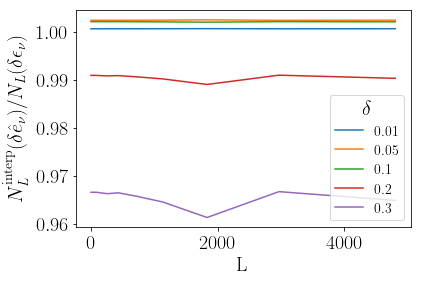

In [41]:
plt.clf()
deltas = np.array([0.01,0.05,0.1,0.2,0.3])
for d in deltas: 
   ep = fun_e(2)*d/0.01
   plt.plot(lCen,NqCmb_interp(ep)/NqCmb(ep),label=str(d))

plt.legend(loc=0,fontsize='x-small',title=r'$\delta$')
plt.xlabel('L')
plt.ylabel(r'$N^\text{interp}_L(\delta\hat{e}_\nu)/N_L(\delta \epsilon_\nu)$')
plt.savefig('output/noise_interp_ratio_Shear.png',bbox_inches='tight')

In [42]:
def loss(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 =  2. * (ClkCmb + NqCmb_interp(epsilon))**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum(np.abs(2.*np.array(data['Shear primary, CIB'])[I]*Cib_scalefactor**2.+2.*np.array(data['Shear secondary, CIB'])[I]*Cib_scalefactor**2.+np.array(data['Shear trispectrum, CIB'])[I]*Cib_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Tsz = np.sum(np.abs(2.*np.array(data['Shear primary, tSZ'])[I]*Tsz_scalefactor**2.+2.*np.array(data['Shear secondary, tSZ'])[I]*Tsz_scalefactor**2.+np.array(data['Shear trispectrum, tSZ'])[I]*Tsz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Ksz = np.sum(np.abs(2.*np.array(data['Shear primary, kSZ'])[I]*Ksz_scalefactor**2.+2.*np.array(data['Shear secondary, kSZ'])[I]*Ksz_scalefactor**2.+np.array(data['Shear trispectrum, kSZ'])[I]*Ksz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Radiops = np.sum(np.abs(2.*np.array(data['Shear primary, Radio PS'])[I]*Radiops_scalefactor**2.+2.*np.array(data['Shear secondary, Radio PS'])[I]*Radiops_scalefactor**2.+np.array(data['Shear trispectrum, Radio PS'])[I]*Radiops_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm

   bias = Cib**2. + Tsz**2. + Ksz**2. + Radiops**2.
   return np.log(noise + fb*bias)*1.e5


def loss_cross(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 = ((ClkCmb + NqCmb_interp(epsilon))*Cgg + (Ckg)**2) / Nmodes
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum(np.abs(np.array(datax['Shear: CIB'])[I]*Cib_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Tsz = np.sum(np.abs(np.array(datax['Shear: tSZ'])[I]*Tsz_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Ksz = np.sum(np.abs(np.array(datax['Shear: kSZ'])[I]*Ksz_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Radiops = np.sum(np.abs(np.array(datax['Shear: Radio PS'])[I]*Radiops_scalefactor**2.) * Ckg[I] / s2[I]) / norm

   bias = Cib**2. + Tsz**2. + Ksz**2. + Radiops**2.
   return np.log(noise + fb*bias)*1.e5
   

print('optimizing ILC weights')

result = []
for i,fb in enumerate(fbs):
   print(i+1,'out of',len(fbs),end='\r')
   #if len(result) == 0.: epsilon = scipy.optimize.minimize(loss,np.array([0.]*(nBands-2)),args=(fb),method='SLSQP') 
   #else: epsilon = scipy.optimize.minimize(loss,result[-1],args=(fb),method='SLSQP')
   #epsilon = scipy.optimize.differential_evolution(loss,[(-4,4),(-4,4),(-4,4),(-4,4)],args=(np.array([fb]))) 
   epsilon = scipy.optimize.differential_evolution(loss_cross,[(-4,4),(-4,4),(-4,4),(-4,4)],args=(np.array([fb]))) 
   result.append(epsilon.x)
   
epsilons = np.zeros((len(result),nBands))
for i in range(len(result)):
   for j in range(nBands):
      if j == 0: epsilons[i,j]=0.
      elif j < nBands - 1: epsilons[i,j] = np.array(result)[i,j-1]
      elif j == nBands - 1: epsilons[i,j] = -sum(np.array(result)[i,:])
epsilonT = np.transpose(epsilons)

optimizing ILC weights


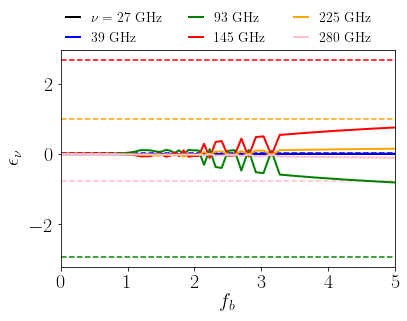

In [43]:
ILC_deproj = cmbIlc.weightsDeprojTszCIB(3000) - cmbIlc.weightsIlcCmb(3000)

plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[0],color='k',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[1],color='b',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[2],color='g',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[3],color='r',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[4],color='orange',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[5],color='pink',ls='--')

plt.plot(fbs,epsilonT[0],color='k',lw=2,label=r'$\nu = 27$ GHz')
plt.plot(fbs,epsilonT[1],color='b',lw=2,label='39 GHz')
plt.plot(fbs,epsilonT[2],color='g',lw=2,label='93 GHz')
plt.plot(fbs,epsilonT[3],color='r',lw=2,label='145 GHz')
plt.plot(fbs,epsilonT[4],color='orange',lw=2,label='225 GHz')
plt.plot(fbs,epsilonT[5],color='pink',lw=2,label='280 GHz')

plt.ylabel(r'$\epsilon_\nu$')
plt.legend(loc=(0,1),frameon=False,fontsize='x-small',ncol=3,handlelength=1)
plt.xlabel(r'$f_b$')
plt.xlim(0,5)
plt.savefig('output/epsilons_varying_loss_functions_SLSQP_Shear.png',bbox_inches='tight')

In [44]:
def bias_to_alens(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 =  2. * (ClkCmb + NqCmb_interp(epsilon))**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum((2.*np.array(data['Shear primary, CIB'])[I]*Cib_scalefactor**2.+2.*np.array(data['Shear secondary, CIB'])[I]*Cib_scalefactor**2.+np.array(data['Shear trispectrum, CIB'])[I]*Cib_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Tsz = np.sum((2.*np.array(data['Shear primary, tSZ'])[I]*Tsz_scalefactor**2.+2.*np.array(data['Shear secondary, tSZ'])[I]*Tsz_scalefactor**2.+np.array(data['Shear trispectrum, tSZ'])[I]*Tsz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Ksz = np.sum((2.*np.array(data['Shear primary, kSZ'])[I]*Ksz_scalefactor**2.+2.*np.array(data['Shear secondary, kSZ'])[I]*Ksz_scalefactor**2.+np.array(data['Shear trispectrum, kSZ'])[I]*Ksz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Radiops = np.sum((2.*np.array(data['Shear primary, Radio PS'])[I]*Radiops_scalefactor**2.+2.*np.array(data['Shear secondary, Radio PS'])[I]*Radiops_scalefactor**2.+np.array(data['Shear trispectrum, Radio PS'])[I]*Radiops_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm

   return np.array([Cib,Tsz,Ksz,Radiops,np.sqrt(noise)])

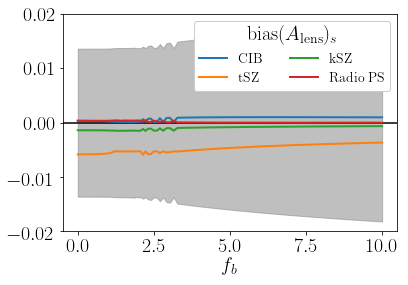

In [45]:
plt.axhline(0,-10,10,color='k')  
plt.fill_between(fbs,[-bias_to_alens(peps)[4] for peps in result],\
[bias_to_alens(peps)[4] for peps in result],color='gray',alpha=0.5)
plt.plot(fbs,[bias_to_alens(peps)[0] for peps in result],label='CIB',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[1] for peps in result],label='tSZ',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[2] for peps in result],label='kSZ',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[3] for peps in result],label='Radio PS',lw=2)
plt.legend(loc=0,frameon=True,framealpha=1,fontsize='x-small',ncol=2,\
           title=r'$\text{bias}(A_\text{lens})_s$')
plt.xlabel(r'$f_b$')
plt.savefig('output/prim_bias_and_noise_vs_fb_Shear.png',bbox_inches='tight')

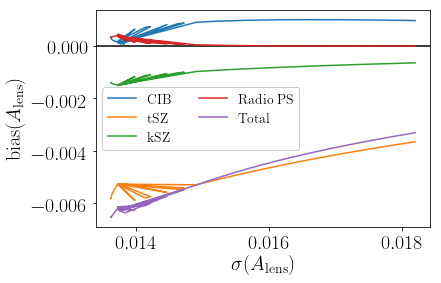

In [46]:
biases_Shear = np.array([bias_to_alens(peps) for peps in result])

plt.axhline(0,-10,10,color='k')

plt.plot(biases_Shear[:,4],biases_Shear[:,0],label='CIB')
plt.plot(biases_Shear[:,4],biases_Shear[:,1],label='tSZ')
plt.plot(biases_Shear[:,4],biases_Shear[:,2],label='kSZ')
plt.plot(biases_Shear[:,4],biases_Shear[:,3],label='Radio PS')
plt.plot(biases_Shear[:,4],biases_Shear[:,0]+biases_Shear[:,1]+biases_Shear[:,2]+biases_Shear[:,3],label='Total')


plt.legend(loc=0,frameon=True,framealpha=1,fontsize='x-small',ncol=2)
plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')
plt.savefig('output/bias_vs_noise_Shear.png',bbox_inches='tight')

# Point Source Hardened Estimator

In [47]:
##########################################################################################################################
## Bias Hardened against point sources

def NqCmb(epsilon):  
   #fCtotal =  lambda l: ctot(weights,l)
   fCtotal = np.array([ctot(epsilon,l,lindex) for lindex,l in enumerate(L)])
   interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
   return baseMap.forecastN0KappaBH(cmb[0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)(lCen)

def fun_e(i):
   result = np.zeros(6)
   result[i] = 0.01
   return result

def fun_e2(i,j):
   result = np.zeros(6)
   result[i] = 0.01
   result[j] = 0.01
   if i == j: result[i] = 0.02
   return result

print('calculating ILC noise')
n0 = NqCmb(np.zeros(6))

normal_points = np.array([None]*6)
matrix_points = np.array([[None]*6]*6)

print('calculating normal points')
for i in range(6): normal_points[i] = NqCmb(fun_e(i))

print('calculating off-diagonal points')
for i in range(6):
   for j in range(i+1):
      matrix_points[i,j] = NqCmb(fun_e2(i,j))

hessian = np.array([[None]*6]*6)
der = np.array([None]*6)
for i in range(6):
   for j in range(i+1):    
      hessian[i,j] = matrix_points[i,j] - normal_points[i] - normal_points[j] + n0
      hessian[i,j] /= 0.01**2.

for i in range(6): 
   der[i] = normal_points[i]-n0
   der[i] /= 0.01

def NqCmb_interp(epsilon):
   result = n0.copy()
   for i in range(6): 
      result += 0.5 * hessian[i,i] * epsilon[i]**2.
      result += der[i] * epsilon[i]
   for i in range(6):
      for j in range(i):
         result += hessian[i,j] * epsilon[i] * epsilon[j]
   return result

calculating ILC noise
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT


flat_map.py:4420: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
flat_map.py:4420: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


Doing full calculation: computeQuadEstPhiNormalizationFFT


flat_map.py:4638: RuntimeWarning: invalid value encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)
flat_map.py:4640: RuntimeWarning: invalid value encountered in less
  where = lnfln(np.log(L)) < np.inf


calculating normal points
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2Norma

/home/noah/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in subtract
/home/noah/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in subtract


computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT


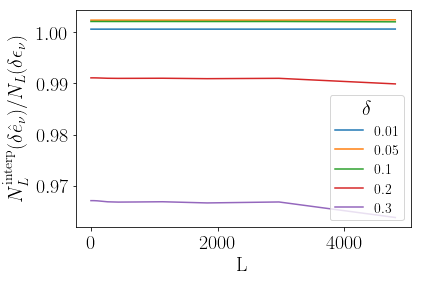

In [48]:
deltas = np.array([0.01,0.05,0.1,0.2,0.3])
for d in deltas: 
   ep = fun_e(2)*d/0.01
   plt.plot(lCen,NqCmb_interp(ep)/NqCmb(ep),label=str(d))

plt.legend(loc=0,fontsize='x-small',title=r'$\delta$')
plt.xlabel('L')
plt.ylabel(r'$N^\text{interp}_L(\delta\hat{e}_\nu)/N_L(\delta \epsilon_\nu)$')
plt.savefig('output/noise_interp_ratio_BH.png',bbox_inches='tight')

In [49]:
def loss(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 =  2. * (ClkCmb + NqCmb_interp(epsilon))**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum(np.abs(2.*np.array(data['PSH primary, CIB'])[I]*Cib_scalefactor**2.+2.*np.array(data['PSH secondary, CIB'])[I]*Cib_scalefactor**2.+np.array(data['PSH trispectrum, CIB'])[I]*Cib_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Tsz = np.sum(np.abs(2.*np.array(data['PSH primary, tSZ'])[I]*Tsz_scalefactor**2.+2.*np.array(data['PSH secondary, tSZ'])[I]*Tsz_scalefactor**2.+np.array(data['PSH trispectrum, tSZ'])[I]*Tsz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Ksz = np.sum(np.abs(2.*np.array(data['PSH primary, kSZ'])[I]*Ksz_scalefactor**2.+2.*np.array(data['PSH secondary, kSZ'])[I]*Ksz_scalefactor**2.+np.array(data['PSH trispectrum, kSZ'])[I]*Ksz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Radiops = np.sum(np.abs(2.*np.array(data['PSH primary, Radio PS'])[I]*Radiops_scalefactor**2.+2.*np.array(data['PSH secondary, Radio PS'])[I]*Radiops_scalefactor**2.+np.array(data['PSH trispectrum, Radio PS'])[I]*Radiops_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm

   bias = Cib**2. + Tsz**2. + Ksz**2. + Radiops**2.
   return np.log(noise + fb*bias)*1.e5


def loss_cross(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 = ((ClkCmb + NqCmb_interp(epsilon))*Cgg + (Ckg)**2) / Nmodes
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum(np.abs(np.array(datax['PSH: CIB'])[I]*Cib_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Tsz = np.sum(np.abs(np.array(datax['PSH: tSZ'])[I]*Tsz_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Ksz = np.sum(np.abs(np.array(datax['PSH: kSZ'])[I]*Ksz_scalefactor**2.) * Ckg[I] / s2[I]) / norm
   #
   Radiops = np.sum(np.abs(np.array(datax['PSH: Radio PS'])[I]*Radiops_scalefactor**2.) * Ckg[I] / s2[I]) / norm

   bias = Cib**2. + Tsz**2. + Ksz**2. + Radiops**2.
   return np.log(noise + fb*bias)*1.e5
   

print('optimizing ILC weights')

result = []
for i,fb in enumerate(fbs):
   print(i+1,'out of',len(fbs),end='\r')
   #if len(result) == 0.: epsilon = scipy.optimize.minimize(loss,np.array([0.]*(nBands-2)),args=(fb),method='SLSQP') 
   #else: epsilon = scipy.optimize.minimize(loss,result[-1],args=(fb),method='SLSQP')
   #epsilon = scipy.optimize.differential_evolution(loss,[(-4,4),(-4,4),(-4,4),(-4,4)],args=(np.array([fb]))) 
   epsilon = scipy.optimize.differential_evolution(loss_cross,[(-4,4),(-4,4),(-4,4),(-4,4)],args=(np.array([fb]))) 
   result.append(epsilon.x)
   
epsilons = np.zeros((len(result),nBands))
for i in range(len(result)):
   for j in range(nBands):
      if j == 0: epsilons[i,j]=0.
      elif j < nBands - 1: epsilons[i,j] = np.array(result)[i,j-1]
      elif j == nBands - 1: epsilons[i,j] = -sum(np.array(result)[i,:])
epsilonT = np.transpose(epsilons)

optimizing ILC weights


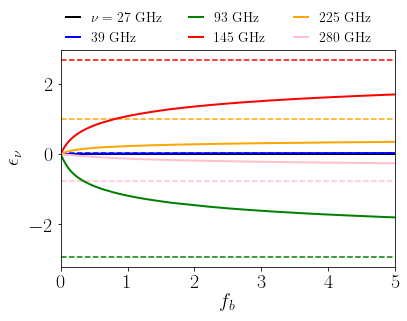

In [50]:
Nu = np.array([27.e9,39.e9,93.e9,145.e9,225.e9,280.e9])
from headers import*
ILC_deproj = cmbIlc.weightsDeprojTszCIB(3000) - cmbIlc.weightsIlcCmb(3000)
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[0],color='k',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[1],color='b',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[2],color='g',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[3],color='r',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[4],color='orange',ls='--')
plt.plot(fbs,np.ones(fbs.shape)*ILC_deproj[5],color='pink',ls='--')

plt.plot(fbs,epsilonT[0],color='k',lw=2,label=r'$\nu = 27$ GHz')
plt.plot(fbs,epsilonT[1],color='b',lw=2,label='39 GHz')
plt.plot(fbs,epsilonT[2],color='g',lw=2,label='93 GHz')
plt.plot(fbs,epsilonT[3],color='r',lw=2,label='145 GHz')
plt.plot(fbs,epsilonT[4],color='orange',lw=2,label='225 GHz')
plt.plot(fbs,epsilonT[5],color='pink',lw=2,label='280 GHz')

plt.ylabel(r'$\epsilon_\nu$')
plt.legend(loc=(0,1),frameon=False,fontsize='x-small',ncol=3,handlelength=1)
plt.xlabel(r'$f_b$')
plt.xlim(0,5)
plt.savefig('output/epsilons_varying_loss_functions_SLSQP_BH.png',bbox_inches='tight')

In [51]:
def bias_to_alens(partial_eps,fb=0.5):
   epsilon = np.array([0.]+list(partial_eps)+[-sum(partial_eps)])

   s2 =  2. * (ClkCmb + NqCmb_interp(epsilon))**2. / Nmodes 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm

   weights = ILC_weights_lmaxT_3000+epsilon
   #
   Cib_scalefactor = sum([cmb[0].cibPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].cibPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   Tsz_scalefactor = sum([cmb[0].tszFreqDpdceT(Nu[i])*weights[i]/cmb[0].tszFreqDpdceT(148.e9) for i in range(nBands)])
   Ksz_scalefactor = sum([cmb[0].kszFreqDpdceT(Nu[i])*weights[i]/cmb[0].kszFreqDpdceT(148.e9) for i in range(nBands)])
   Radiops_scalefactor = sum([cmb[0].radioPoissonFreqDpdceT(Nu[i])*weights[i]/cmb[0].radioPoissonFreqDpdceT(148.e9) for i in range(nBands)])
   #
   Cib = np.sum((2.*np.array(data['PSH primary, CIB'])[I]*Cib_scalefactor**2.+2.*np.array(data['PSH secondary, CIB'])[I]*Cib_scalefactor**2.+np.array(data['PSH trispectrum, CIB'])[I]*Cib_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Tsz = np.sum((2.*np.array(data['PSH primary, tSZ'])[I]*Tsz_scalefactor**2.+2.*np.array(data['PSH secondary, tSZ'])[I]*Tsz_scalefactor**2.+np.array(data['PSH trispectrum, tSZ'])[I]*Tsz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Ksz = np.sum((2.*np.array(data['PSH primary, kSZ'])[I]*Ksz_scalefactor**2.+2.*np.array(data['PSH secondary, kSZ'])[I]*Ksz_scalefactor**2.+np.array(data['PSH trispectrum, kSZ'])[I]*Ksz_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm
   #
   Radiops = np.sum((2.*np.array(data['PSH primary, Radio PS'])[I]*Radiops_scalefactor**2.+2.*np.array(data['PSH secondary, Radio PS'])[I]*Radiops_scalefactor**2.+np.array(data['PSH trispectrum, Radio PS'])[I]*Radiops_scalefactor**4. ) * ClkCmb[I] / s2[I]) / norm

   return np.array([Cib,Tsz,Ksz,Radiops,np.sqrt(noise)])

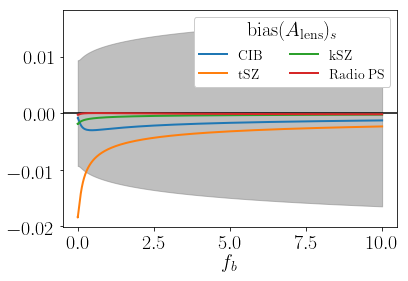

In [52]:
plt.axhline(0,-10,10,color='k')  
plt.fill_between(fbs,[-bias_to_alens(peps)[4] for peps in result],\
[bias_to_alens(peps)[4] for peps in result],color='gray',alpha=0.5)
plt.plot(fbs,[bias_to_alens(peps)[0] for peps in result],label='CIB',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[1] for peps in result],label='tSZ',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[2] for peps in result],label='kSZ',lw=2)
plt.plot(fbs,[bias_to_alens(peps)[3] for peps in result],label='Radio PS',lw=2)
plt.legend(loc=0,frameon=True,framealpha=1,fontsize='x-small',ncol=2,\
           title=r'$\text{bias}(A_\text{lens})_s$')
plt.xlabel(r'$f_b$')
plt.savefig('output/prim_bias_and_noise_vs_fb_BH.png',bbox_inches='tight')

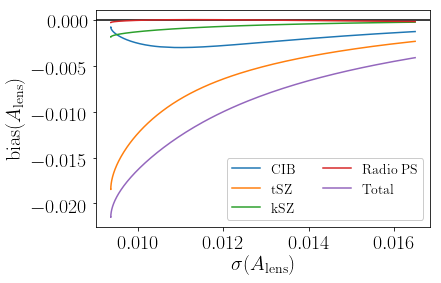

In [53]:
biases_PSH = np.array([bias_to_alens(peps) for peps in result])

plt.axhline(0,-10,10,color='k')

plt.plot(biases_PSH[:,4],biases_PSH[:,0],label='CIB')
plt.plot(biases_PSH[:,4],biases_PSH[:,1],label='tSZ')
plt.plot(biases_PSH[:,4],biases_PSH[:,2],label='kSZ')
plt.plot(biases_PSH[:,4],biases_PSH[:,3],label='Radio PS')
plt.plot(biases_PSH[:,4],biases_PSH[:,0]+biases_PSH[:,1]+biases_PSH[:,2]+biases_PSH[:,3],label='Total')

plt.legend(loc=0,frameon=True,framealpha=1,fontsize='x-small',ncol=2)
plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')
plt.savefig('output/bias_vs_noise_BH.png',bbox_inches='tight')

# All estimators

/home/noah/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


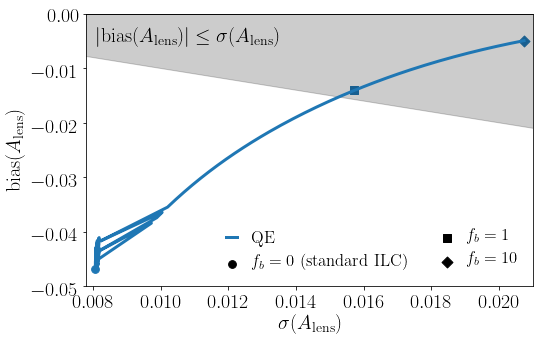

In [70]:
plt.figure(figsize=(8,5))

plt.axhline(0,-10,10,color='k')

plt.plot(biases_QE[:,4],biases_QE[:,0]+biases_QE[:,1]+biases_QE[:,2]+biases_QE[:,3],label='QE',lw=3)
#plt.plot(biases_PSH[:,4],biases_PSH[:,0]+biases_PSH[:,1]+biases_PSH[:,2]+biases_PSH[:,3],label='PSH',lw=3)
#plt.plot(biases_Shear[:,4],biases_Shear[:,0]+biases_Shear[:,1]+biases_Shear[:,2]+biases_Shear[:,3],label='Shear',lw=2)

plt.scatter(biases_QE[:,4][0],(biases_QE[:,0]+biases_QE[:,1]+biases_QE[:,2]+biases_QE[:,3])[0],c='C0',s=60)
#plt.scatter(biases_PSH[:,4][0],(biases_PSH[:,0]+biases_PSH[:,1]+biases_PSH[:,2]+biases_PSH[:,3])[0],c='C1',s=60)
#plt.scatter(biases_Shear[:,4][0],(biases_Shear[:,0]+biases_Shear[:,1]+biases_Shear[:,2]+biases_Shear[:,3])[0],c='C2',s=60)

plt.scatter(biases_QE[:,4][240],(biases_QE[:,0]+biases_QE[:,1]+biases_QE[:,2]+biases_QE[:,3])[240],c='C0',marker='s',s=60)
#plt.scatter(biases_PSH[:,4][240],(biases_PSH[:,0]+biases_PSH[:,1]+biases_PSH[:,2]+biases_PSH[:,3])[240],c='C1',marker='s',s=60)
#plt.scatter(biases_Shear[:,4][240],(biases_Shear[:,0]+biases_Shear[:,1]+biases_Shear[:,2]+biases_Shear[:,3])[240],c='C2',marker='s',s=60)

plt.scatter(biases_QE[:,4][-1],(biases_QE[:,0]+biases_QE[:,1]+biases_QE[:,2]+biases_QE[:,3])[-1],c='C0',marker='D',s=60)
#plt.scatter(biases_PSH[:,4][-1],(biases_PSH[:,0]+biases_PSH[:,1]+biases_PSH[:,2]+biases_PSH[:,3])[-1],c='C1',marker='D',s=60)
#plt.scatter(biases_Shear[:,4][-1],(biases_Shear[:,0]+biases_Shear[:,1]+biases_Shear[:,2]+biases_Shear[:,3])[-1],c='C2',marker='D',s=60)

plt.xlabel(r'$\sigma(A_\text{lens})$')
plt.ylabel(r'$\text{bias}(A_\text{lens})$')
plt.savefig('output/bias_vs_noise_BH.png',bbox_inches='tight')

x = np.linspace(0.0075,0.21,10)
plt.fill_between(x,-x,np.zeros(x.shape),color='k',alpha=0.2)
plt.text(0.0081,-0.0055,r'$|\text{bias}(A_\text{lens})| \leq \sigma(A_\text{lens})$')

plt.scatter([],[],c='k',s=60,label=r'$f_b=0$ (standard ILC)')
plt.scatter([],[],c='k',s=60,marker='s',label=r'$f_b=1$')
plt.scatter([],[],c='k',s=60,marker='D',label=r'$f_b=10$')


plt.legend(loc=0,frameon=False,framealpha=1,fontsize='small',ncol=2,handlelength=0.7)
plt.ylim(-0.05,0)
plt.xlim(0.0078,0.021)
plt.savefig('figures/bias_vs_noise.png',bbox_inches='tight')